In [1]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpyro.handlers
import pandas as pd
import pymc as pm
import networkx as nx
# import xarray as xr
import seaborn as sns 
# from scipy.special import expit, logit
import scipy as sp
from itertools import combinations
from scipy.spatial.distance import cdist

import os


import jax
import jax.numpy as jnp
from jax import random, jit, vmap
from jax.scipy.special import expit, logsumexp, logit
from functools import partial
import numpyro.distributions as dist 
import numpyro
from numpyro.contrib.funsor import config_enumerate
# from numpyro.infer.reparam import LocScaleReparam

# from numpyro.util import set_host_device_count
# from numpyro.contrib.control_flow import scan
# from numpyro.ops.indexing import Vindex
from tqdm import tqdm
# from joblib import Parallel, delayed

from numpyro import handlers
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, MixedHMC, Predictive
import pyro
# import pymc_experimental as pmx

import multiprocessing
import socket

import hsgp.approximation
from hsgp.approximation import hsgp_squared_exponential, eigenfunctions
from hsgp.spectral_densities import diag_spectral_density_squared_exponential
# from numpyro.contrib.hsgp.approximation import hsgp_squared_exponential

print(f"Running on PyMC v{pm.__version__}")
# print(f"Running on PyMC-experimental v{pmx.__version__}")
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on Pyro v{pyro.__version__}")
print(f"Running on JAX v{jax.__version__}")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.15.1
Running on NumPyro v0.15.2
Running on Pyro v1.9.1
Running on JAX v0.4.25


In [2]:
# Set CPU for JAX
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
print(jax.devices('cpu'))

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [3]:
RANDOM_SEED = 89253
# rng = np.random.default_rng(RANDOM_SEED)
rng = np.random.default_rng(7)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

(array([4.1671e+04, 3.5104e+04, 2.4059e+04, 1.3812e+04, 6.5970e+03,
        2.5040e+03, 7.5600e+02, 1.9600e+02, 4.4000e+01, 7.0000e+00]),
 array([3.35014265e-05, 1.73654068e+00, 3.47304773e+00, 5.20955467e+00,
        6.94606209e+00, 8.68256950e+00, 1.04190760e+01, 1.21555834e+01,
        1.38920908e+01, 1.56285973e+01, 1.73651047e+01]),
 <BarContainer object of 10 artists>)

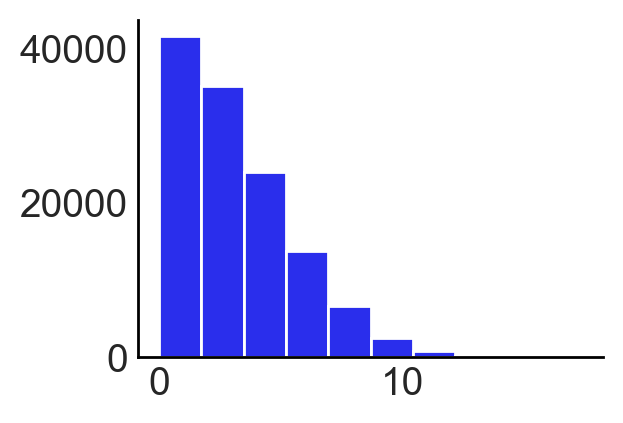

In [4]:
# n=150
# n=300
n=500
tril_dim = int(n*(n-1)/2)  
# x = rng.integers(low=0,high=1,size=n,endpoint=True)
x = rng.normal(loc=0,scale=3,size=n)
# x = rng.standard_t(df=10, size= n)
# x = rng.uniform(size=n,low=-3,high=3)
# x = rng.standard_t(size=n,df=5)
x2 = rng.binomial(n=1,p=0.1,size=n)

U_latent = rng.normal(loc=0,scale=1,size=(n,2))
# x2 = np.random.choice(["A","B","C"], size = n, p=[0.25,0.35,0.6])
# x_diff = []
# # x2_equal =[]
# for i in range(n):
#     for j in range(i+1,n):
#         x_diff.append(np.abs(x[i]-x[j]))
#         # x2_equal.append(x2[i]==x2[j])
# x_diff = np.array(x_diff)
# x2_equal = np.array(x2_equal)
# plt.hist(x_diff)
# Create probs
# beta = -3, -.5,2 
# beta = -2, -.5

idx_pairs = list(combinations(range(len(x)),2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])

x2_equal = jnp.array([1 if x2[i]==1 and x2[j]==1 else 0 for i,j in idx_pairs])
# x2_or = np.array([1 if (x2[i]==1 or x2[j]==1) and (x2[i]!=x2[j]) else 0 for i,j in idx_pairs])
# x2_or = jnp.array([1 if (x2[i]==1 or x2[j]==1) else 0 for i,j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i,j in idx_pairs])

plt.figure(figsize=(3,2))
plt.hist(x_diff)


In [5]:
jnp.dot(U_latent, U_latent.T).shape

(500, 500)

In [6]:
# idx = jnp.triu_indices(n=n, k=1)
# U_diff = U_latent[idx[0]] - U_latent[idx[1]]
# U_diff_norm_val = jnp.linalg.norm(U_diff, axis=1)

def latent_to_norm_of_diff(U):
    idx = jnp.triu_indices(n=U.shape[0], k=1)
    U_diff = U[idx[0]] - U[idx[1]]
    # print(U_diff.shape)
    return jnp.linalg.norm(U_diff, axis=1)


def cosine_similarity_jax(U):
    # Normalize the rows
    U_normalized = U / jnp.linalg.norm(U, axis=1, keepdims=True)
    
    # Compute dot products for upper triangle
    n = U.shape[0]
    triu_indices = jnp.triu_indices(n, k=1)
    dot_products = jnp.dot(U_normalized, U_normalized.T)[triu_indices]
    
    return dot_products

U_diff_norm_val = latent_to_norm_of_diff(U_latent)
U_cosine = cosine_similarity_jax(U_latent)

In [7]:
print(x2_or.mean(), U_diff_norm_val.shape, n*(n-1)/2, U_diff_norm_val.mean(), U_cosine.mean(), U_cosine.shape)
print(jnp.sum(U_cosine > 0) / U_cosine.shape[0], jnp.sum(U_cosine < 0) / U_cosine.shape[0])

0.1803607 (124750,) 124750.0 1.8115761 0.002754917 (124750,)
0.5013307 0.49866933


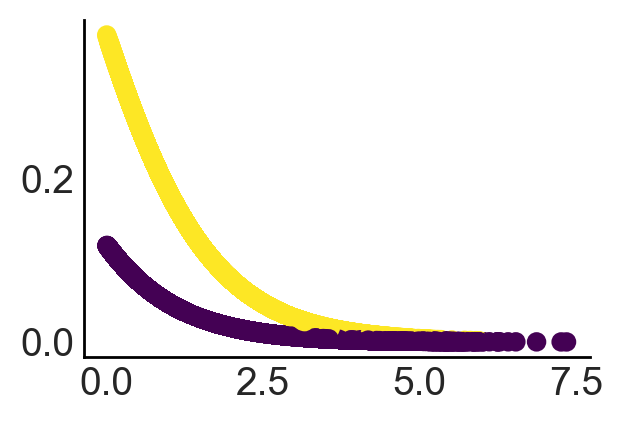

In [8]:
# beta = -2, -.5
beta = -2, -.5
# beta = -2, -1
# probs = expit(beta[0] + beta[1]*x_diff + rng.normal(-.5,1,tril_dim))
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + 2*x2_or)
# probs = expit(-2.5  + 1.5*x2_or)
probs = expit(-2  + 1.5*x2_or - U_diff_norm_val)
# probs = expit(-3  + 1*x2_or + U_cosine)


plt.figure(figsize=(3,2))
# plt.scatter(x_diff,probs, c=x2_or)
plt.scatter(U_diff_norm_val,probs, c=x2_or)
# plt.scatter(U_cosine,probs, c=x2_or)

# Generate adj. matrix
mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges = rng.binomial(n=1,p=probs,size=tril_dim)

mat[idx_ut] = edges
# mat[idx_lt] = edges
mat = mat + mat.T
triu_vals = mat[np.triu_indices(n,k=1)]





In [9]:
# def eigen_centrality(adj_mat):
#     sparse_mat = sp.sparse.csr_matrix(adj_mat)
#     _, eig_vec = sp.sparse.linalg.eigs(sparse_mat, k=1, which = 'LR')
#     largest_v = eig_vec.flatten().real
#     norm = np.sign(largest_v.sum()) * sp.linalg.norm(largest_v)
#     return largest_v / norm

@jit
def eigen_centrality(adj_mat):
    # Ensure the matrix is symmetric
    # adj_mat = (adj_mat + adj_mat.T) / 2
    
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = jnp.linalg.eigh(adj_mat)
    
    # Find the index of the largest eigenvalue
    largest_eigenvalue_index = jnp.argmax(eigenvalues)
    
    # Get the corresponding eigenvector
    largest_eigenvector = eigenvectors[:, largest_eigenvalue_index]
    
    # Scale the eigenvector
    norm = jnp.sign(largest_eigenvector.sum()) * jnp.linalg.norm(largest_eigenvector)
    scaled_eigenvector = largest_eigenvector / norm
    
    return scaled_eigenvector

In [10]:
eigen_center = eigen_centrality(mat)
# eigen_center_jx = eigen_centrality_jax(mat)

# print(jnp.array_equal(jnp.round(eigen_center,5), jnp.round(eigen_center_jx,5)))

# plt.figure(figsize=(3,2))
# plt.scatter(eigen_center, eigen_center_jx)


23.092


(array([ 37., 141., 180.,  85.,  17.,   9.,  11.,  10.,   3.,   7.]),
 array([ 1. ,  9.3, 17.6, 25.9, 34.2, 42.5, 50.8, 59.1, 67.4, 75.7, 84. ]),
 <BarContainer object of 10 artists>)

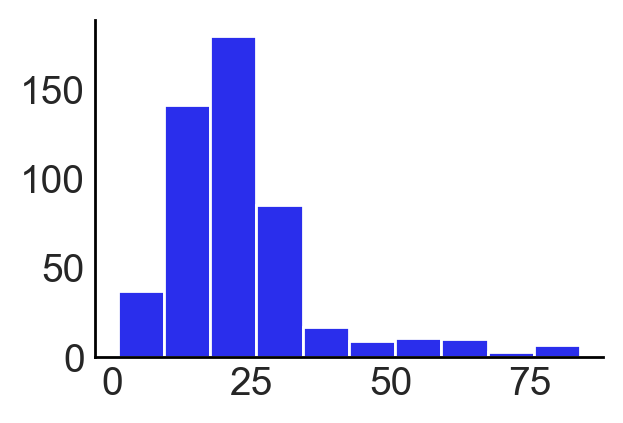

In [11]:
plt.figure(figsize=(3,2))
print(np.mean(np.sum(mat,axis=1)))
plt.hist(np.sum(mat,axis=1))

In [ ]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

deg_, cdf_ = ecdf(np.sum(mat,axis=1))

plt.figure(figsize=(3, 2))
plt.scatter(deg_, 1-cdf_)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Data Points')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function (Log-Log Scale)')
plt.grid(True, which='both', linestyle='--')
plt.show()


sum eigen 19.694363


(array([ 36., 117., 158., 108.,  40.,  17.,  13.,   4.,   5.,   2.]),
 array([0.00050172, 0.01419922, 0.02789672, 0.04159421, 0.05529172,
        0.06898922, 0.08268671, 0.09638421, 0.11008171, 0.12377921,
        0.13747671]),
 <BarContainer object of 10 artists>)

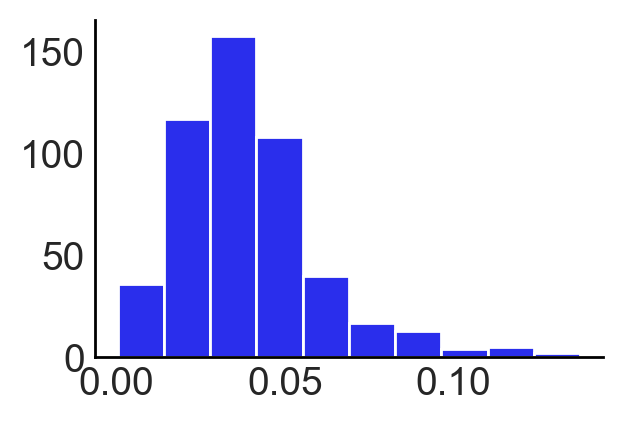

In [12]:
print("sum eigen", np.sum(eigen_center))
plt.figure(figsize=(3,2))
plt.hist(eigen_center)

In [ ]:
# mat_net = nx.from_numpy_array(mat)
# 
# degrees = np.array([degree for _, degree in mat_net.degree()])
# deg_center = np.array(list(nx.degree_centrality(mat_net).values()))
# eigen_center = np.array(list(nx.eigenvector_centrality_numpy(mat_net).values()))
# closeness = np.array(list(nx.closeness_centrality(mat_net).values()))
# betweeness = np.array(list(nx.betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.current_flow_betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.approximate_current_flow_betweenness_centrality(mat_net,epsilon=0.1).values()))
# triangles = np.array(list(nx.triangles(mat_net).values()))
# clustering = np.array(list(nx.clustering(mat_net).values()))


In [ ]:
# print(min(betweeness),max(betweeness))
# print(min(eigen_center),max(eigen_center))
# print(min(triangles),max(triangles))


In [13]:
@jit
def zeigen_value(Z, eig_cen, A_mat):
    if Z.ndim == 1:  # Case when Z has shape (N,)
        return jnp.dot(A_mat, Z * eig_cen)
    elif Z.ndim == 2:  # Case when Z has shape (M, N)
        return jnp.dot(Z * eig_cen, A_mat.T)  # Transpose A_mat for correct dimensions
    # return jnp.dot(Z*eig_cen, A_mat.T)
    # return jnp.dot(A_mat, Z*eig_cen)
    # return jnp.dot(A_mat, Z*eig_cen)
    # return jnp.dot(A_mat, jnp.multiply(Z, eig_cen))

           zeigen       expos  exposinv           Z
count  500.000000  500.000000   500.000  500.000000
mean     0.587975    0.492613   360.216    0.486000
std      0.333857    0.122237   187.277    0.500305
min      0.004431    0.150000     5.000    0.000000
25%      0.362210    0.416667   226.500    0.000000
50%      0.553151    0.484360   340.000    0.000000
75%      0.755334    0.562500   476.000    1.000000
max      2.288430    1.000000  1204.000    1.000000
[[1.         0.22472427]
 [0.22472427 1.        ]]


(array([ 61., 129., 146., 102.,  33.,  14.,   8.,   4.,   2.,   1.]),
 array([0.00443099, 0.23283091, 0.46123084, 0.68963075, 0.91803068,
        1.14643061, 1.37483048, 1.60323048, 1.83163035, 2.06003022,
        2.28843021]),
 <BarContainer object of 10 artists>)

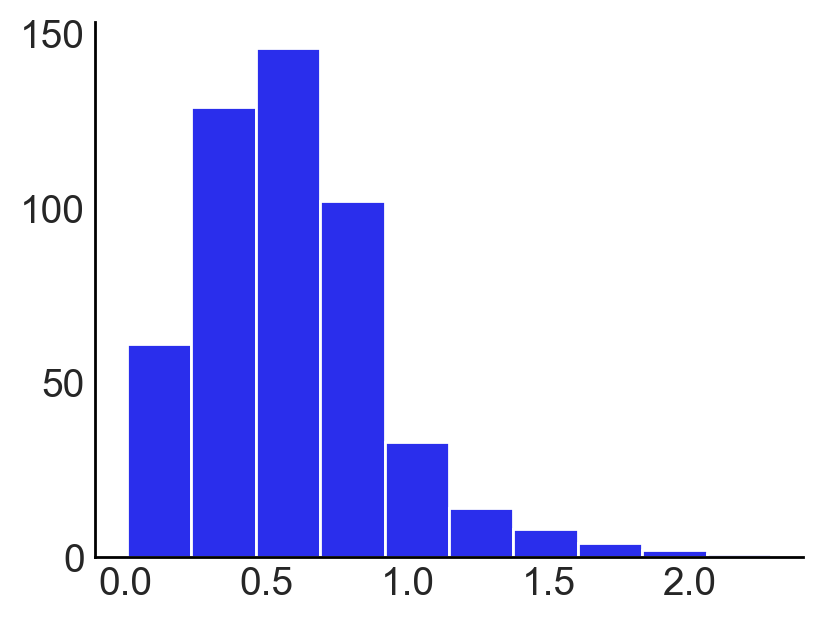

In [14]:
# Create outcome data

Z = rng.binomial(n=1,p=0.5,size=n)
degrees = np.sum(mat,1)
exposures = np.dot(mat,Z) / degrees
exposures_inv_deg = np.dot(mat,Z*degrees)
# print(pd.DataFrame(exposures).describe())
# x_neighbors = np.dot(mat,x) / degrees
# print(pd.DataFrame(x_neighbors).describe())
# print(pd.DataFrame(x).describe())

# Zeigen = np.dot(mat, Z*eigen_center)
Zeigen = zeigen_value(Z, eigen_center, mat)

print(pd.DataFrame({"zeigen": Zeigen,"expos" : exposures, "exposinv":exposures_inv_deg,
                    "Z" : Z}).describe())
print(np.corrcoef(Zeigen,exposures))
# expos_binary = exposures > 0.5
# print(np.mean(expos_binary))

plt.figure(figsize=(4,3))
plt.hist(Zeigen)
# plt.scatter(exposures, Zeigen)
# plt.scatter(exposures_inv_deg, exposures)

In [ ]:
oned = zeigen_value(Z, eigen_center, mat)
multid = zeigen_value(Z.reshape((1,n)), eigen_center, mat)
multid_m = jnp.mean(multid, axis=0)
print(oned.shape)
print(multid.shape)
print(multid_m.shape)
print(jnp.array_equal(jnp.round(oned, 4), jnp.round(multid_m,4)))

In [ ]:
print(np.mean((0.7 < Zeigen) & (Zeigen < 1)))
print(np.mean((0.8 >= Zeigen)))
print(np.mean((1 <= Zeigen)))
print(np.mean((1.7 <= Zeigen)))
print(np.mean((1.2 > Zeigen)))


In [ ]:
s = np.sort(Zeigen)
s -= 0.1
# f1 = 2.5*s
# f2 = 0*(x < 0.25) + 0.2*np.exp(2*x)*(x>=0.25)
# f2 = 0*(s < 0.2) + 5*2.5*np.power(s-0.2, 2)*(s>=0.2)

def f2(s):
    return np.piecewise(s, 
                        # [s < .8, (s >= .8) & (s < 1), s >= 1], 
                        # [s <= 0.6, (s < 1) & (s > 0.6), s >= 1], 
                        [s <= 1.2, s > 1.2], 
                        # [lambda s: 0, lambda s: 15*2.5*np.power(s-0.3, 2), 15*2.5*np.power(0.6-0.3, 2)])
                        # [lambda s: np.maximum(5*2.5*(s-1), 0), lambda s: np.maximum(5*2.5*0.4 - 2.5*2.5*(s - 1), 0)])
                        [lambda s: np.maximum(8*2.5*(s-.8), 0), lambda s: np.maximum(6*2.5*0.5 - 3*2.5*(s - 1.3), 0)])

def f(x):
    # return 2.5*(np.sin(10 * x) + np.cos(3 * x))
    # return 2.5*(np.sin(4*np.pi * x) + np.log(x+1))
    # return 1.5*2.5*(np.sin(2.5*(x-.25)) + np.log(x + 1))
    return 1.2*2.5*(np.sin(4*(x-np.pi)) + np.log(x + 1))


f0 = 2.5*s
f1 = f(s)
f2v= f2(s)
# f3 = 2.5*2 / (1+np.exp(-10*(s-0.8)))
# f3 = 2.5*2.5 / (1+np.exp(-5*s + 7.5))
# f3 = np.exp(2.5*s)/150
f3 = np.maximum(-5*np.power(s-1,2) + 2.5*3*np.log(s+1), 0)
f4 = np.maximum(0, np.minimum(4*2.5*(s-.4),4*2.5*0.3))
# f4 = np.maximum(0, np.minimum(8*2.5*(s-1.2),4*2.5*(s-1.1)))
print(np.mean(f2v), np.median(f2v))
# f4 = np.maximum(0, 2*2.5*(s-1.5))
# f3 = -2.5*3*np.power(s- 1,2) + 3*2.5*s

plt.figure(figsize=(3,2))
plt.scatter(s,f0, c="darkgreen")
# plt.scatter(s,f1, c="red")
plt.scatter(s,4*s*Z + f4, c="red")
# plt.scatter(s,f2v, c="blue")
# plt.scatter(s,f3, c="violet")
# plt.scatter(s,f4, c="orange")
# plt.axvline(0.25, c="black")


In [45]:
# alpha = -.5, 2, 1, -1
# alpha = -1, 3, 1, 0.5, -0.25
# alpha = -.5, 2, .5, 0.25, -0.25
# alpha = -.5, 2, 0.5, -0.25, -0.25
# alpha = -2, 3, 1, -.5
# alpha = -1, 3, 2, -.25, 5, 5 
# alpha = -1, 3, -.25, 2.5, 2 

def f_zeigen(s, param):
    # Conditions
    cond1 = s <= 1.3
    # cond1 = s < .8
    # cond2 = (s >= .6) & (s < 1)
    # cond3 = s >= 1
    # Functions
    # f1 = 0
    # f1 = 4 * param * s
    f2 = np.maximum(6 * param * (s - .8) ,0)
    f3 = np.maximum(15*param*(1.3-0.6) - 3*param*(s-1.3), 0)
    # f2 = 4 * param * (0.9 - 0.3)
    # f3 = 10 * param * (1 - .8)
    # Using jnp.where to implement piecewise function
    result = jnp.where(cond1, f2, f3)
    # result = jnp.where(cond1, f1, jnp.where(cond2, f2, f3))
    return result

# alpha = -1, 3, -.25, 3, 2.5 
# alpha = -1, 3, -.25, 0, 2.5 
# alpha = -1, 3, -.25, 1, 2.5 
alpha = -1, 3, -.25, 1, 3 

def gen_y(Z,x, x2, Zeigen, alpha, lin=True):
    epsi = rng.normal(loc=0,scale=1,size=n)
    # dflin = np.transpose(np.array([[1]*n, Z, x, Z*x]))
    dflin = np.transpose(np.array([[1]*n, Z, x, x2]))
    if lin:
        mean_y = np.dot(np.column_stack((dflin,Zeigen)), alpha)
        # mean_y += df_lin[:,1]*df_lin[:,2]
    else:
        # mean_lin = np.dot(dflin[:,0:3], alpha[0:3]) 
        # mean_nonlin = 0*(Zeigen < 0.2) + (alpha[3]*3)*(Zeigen-0.2)*(Zeigen>=0.2)        
        # mean_nonlin = 0*(Zeigen < 0.2)  - alpha[3]*(np.log(1-(Zeigen-0.2)/1.1))*(Zeigen>=0.2)        
        # mean_nonlin = alpha[3]*1.5 / (1+np.exp(-15*(Zeigen-0.4)))        
        # mean_nonlin = alpha[3]*(np.sin(10 * Zeigen) + np.log(Zeigen + 1))
        # mean_nonlin = 1.5*alpha[4]*(np.sin(2.5 * (Zeigen-.25)) + np.log(Zeigen + 1))        
        # mean_nonlin = 1.2*alpha[4]*(np.sin(4 * (Zeigen - np.pi)) + np.log(Zeigen + 1))
        # mean_nonlin = np.exp(alpha[4]*Zeigen)/40    
        # mean_nonlin =  -3*alpha[4]*np.power(Zeigen-1,2) + 3*alpha[4]*Zeigen 
        # mean_nonlin = f_zeigen(Zeigen, alpha[4])        
        # mean_nonlin = np.maximum(-2*alpha[4]*np.power(Zeigen-1.2,2) + 2*alpha[4]*Zeigen, 0)        
        # mean_nonlin = np.maximum(-2*alpha[4]*np.power(Zeigen-1.5,2) + 3*alpha[4]*np.log(Zeigen+1), 0)        
        mean_nonlin = np.maximum(0, np.minimum(4*alpha[4]*(Zeigen-.4), 4*alpha[4]*0.3))
        mean_nonlin += 4*Z*Zeigen
        # mean_nonlin += alpha[4]*Z*Zeigen
        # mean_nonlin = np.maximum(0, 2*alpha[4]*(Zeigen-1.5))
        # mean_nonlin = 2*alpha[4] / (1+np.exp(-5*Zeigen + 7.5))  
        # mean_nonlin = alpha[3]*(np.sin(15 * Zeigen) + 2*np.log(Zeigen + 1))        
        # mean_nonlin = alpha[3]*(np.sin(4*np.pi * Zeigen) + np.log(Zeigen + 1))       
        # xz_interaction_sq = np.power(Z*x,2)
        # mean_y = mean_lin + mean_nonlin + 0.25*xz_interaction_sq 
        mean_lin = np.dot(dflin, alpha[0:4]) 
        mean_y = mean_lin + mean_nonlin + 0.25*np.power(Z*x,2)
        # mean_y = mean_lin + mean_nonlin

    Y = mean_y + epsi
    return Y, epsi



(array([ 12.,  41.,  83.,  99., 100.,  85.,  53.,  18.,   6.,   3.]),
 array([-3.0204595 , -1.71721368, -0.41396787,  0.88927795,  2.19252377,
         3.49576958,  4.7990154 ,  6.10226122,  7.40550703,  8.70875285,
        10.01199867]),
 <BarContainer object of 10 artists>)

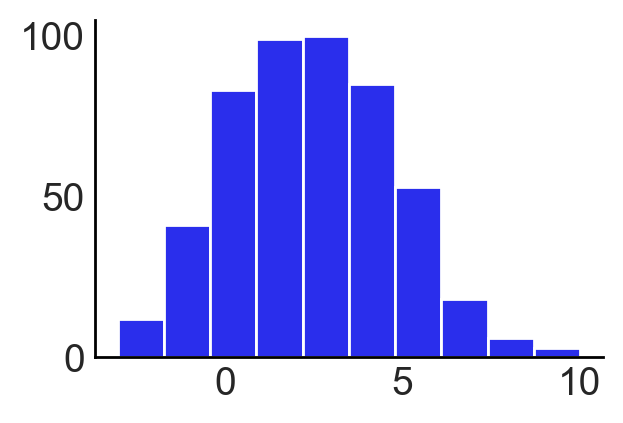

In [46]:
# df_array = np.transpose(np.array([[1]*n,Z,exposures,x,eigen_center,betweeness]))
# df_array = np.transpose(np.array([[1]*n, Z, x, Zeigen,exposures]))

# df_array = np.transpose(np.array([[1]*n, Z, Zeigen]))
df_array = np.transpose(np.array([[1]*n, Z, x, Z*x, Zeigen]))
# df_array = np.transpose(np.array([[1]*n, Z, x,x2, Zeigen]))

df_lin = np.transpose(np.array([[1]*n, Z, x, x2]))
# mean_y = np.dot(df_array,alpha)
# # Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*x + alpha[4] + rng.normal(loc=0,scale=1,size=n)
# epsilon = rng.normal(loc=0,scale=1,size=n)
# Y = mean_y + epsilon

# Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=True)
# Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=False)
# Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=False)
Y, epsilon = gen_y(Z, x,x2, Zeigen, alpha, lin=True)

plt.figure(figsize=(3,2))
plt.hist(Y)


[[1.         0.42109163]
 [0.42109163 1.        ]]


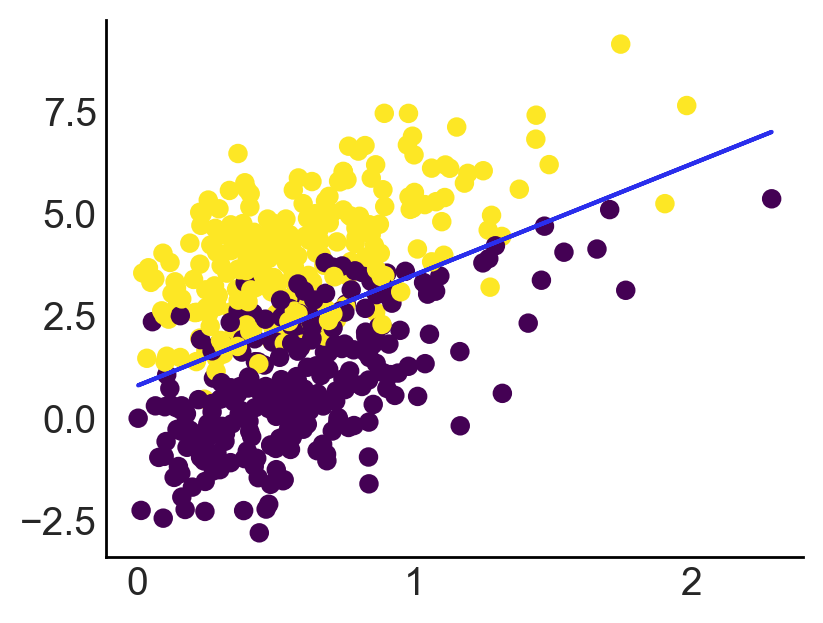

In [23]:
plt.figure(figsize=(4,3))
# plt.scatter(exposures,betweeness)
# plt.scatter(exposures,eigen_center)

# print(np.corrcoef(eigen_center,Zeigen))
print(np.corrcoef(Zeigen,Y))
# plt.scatter(eigen_center,Zeigen)
# plt.scatter(Zeigen,Y,c=Z)
# plt.scatter(Zeigen,Y-epsilon,c=Z)
#create basic scatterplot
# plt.plot(Zeigen, Y, 'o')
# plt.plot(Zeigen, Y, 'o')
plt.scatter(Zeigen, Y, c= Z)
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(Zeigen, Y, 1)
#add linear regression line to scatterplot 
plt.plot(Zeigen, m*Zeigen+b)

# plt.scatter(exposures,Zeigen)
# plt.scatter(exposures/degrees,Zeigen)
# plt.scatter(betweeness,eigen_center)
# plt.hist(Zeigen)
# plt.hist(exposures/degrees)

In [ ]:
# DG = nx.from_numpy_array(mat)
# DG = nx.from_numpy_array(mat)
# nx.set_node_attributes(DG, Z, "Treatments") 
# node_sizes = [DG.degree(node) for node in DG.nodes()]
# # nx.draw(DG,node_color = Z, node_size=node_sizes, width=0.05)
# # nx.draw(DG, nx.kamada_kawai_layout(DG), node_color = eigen_center, node_size=node_sizes, width=0.05)
# nx.draw(DG, nx.kamada_kawai_layout(DG), node_color = Zeigen, node_size=node_sizes, width=0.05)
# # nx.draw(DG, nx.shell_layout(DG), node_color = Zeigen, node_size=node_sizes, width=0.05)
# plt.legend()
# plt.show()

In [ ]:
# Create noisy measurement of `mat`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma2 = 0.01
# 
# # gamma0 = gamma1/5 # add non-existing edge with prob `bet` 
# # gamma0 = 0.05 # add non-existing edge with prob `bet` 
# gamma0 = 0.025 # add non-existing edge with prob `bet` 
# 
# obs_mat = np.zeros((n,n)) # create nXn matrix of zeros
# # obs_mat[np.tril_indices(n=n,k=-1)] = tril_vals # init as true network
# obs_mat[np.triu_indices(n=n,k=1)] = triu_vals # init as true network
# for i in range(0,n): # add noise
#     for j in range(i+1,n):
#         if mat[i,j] == 1:
#             # obs_mat[i,j] = rng.binomial(n=1,p=1-gamma1,size=1)[0] # retain existing edge w.p. `1-gamma1`
#             obs_mat[i,j] = rng.binomial(n=1,p=1-expit(2 - 3*x_diff[]),size=1)[0] # retain existing edge w.p. `1-gamma1`
#         else:
#             obs_mat[i,j] = rng.binomial(n=1,p=gamma0,size=1)[0] # add non-existing edge w.p. `gamma0` 
#             
# obs_mat = obs_mat + obs_mat.T
# triu_obs = obs_mat[np.triu_indices(n=n,k=1)]
# # tril_obs = obs_mat[np.tril_indices(n=n,k=-1)]


In [ ]:
print(logit(1-0.25), expit(1.1), expit(-1), expit(-3.5), expit(-1))

In [ ]:
f = jnp.array([1,2,3,4,5])
# torch.from_numpy(np.array(f))

In [24]:
print(np.mean(x_diff), np.mean(x2_or))

3.1824105 0.1803607


In [33]:
# prob_nois = triu_vals*(1-0.3) + (1-triu_vals)*expit(-1 - .25*x_diff)
# logit_nois = triu_vals*logit(1-0.25) + (1-triu_vals)*(-1.5 - .1*x_diff + .5*x2_equal)
# logit_nois = triu_vals*logit(1-0.25) + (1-triu_vals)*(-2.5 - 1*x2_equal)
# logit_nois = triu_vals*logit(1-0.2) + (1-triu_vals)*(-2 + 1*x2_equal + 0.5*x2_or)
# logit_nois = triu_vals*logit(1-0.2) + (1-triu_vals)*(-2 + 1*x2_equal + 0.5*x2_or)
# logit_nois = triu_vals*logit(0.75) + (1-triu_vals)*(-2 + 1.5*x2_or)
# logit_nois = triu_vals*logit(0.75) + (1-triu_vals)*(-2 - .15*x_diff)

# logit_nois = triu_vals*1.1 + (1-triu_vals)*(-1*x_diff)
# logit_nois = triu_vals*1.1 + (1-triu_vals)*(0.2 - 1*x_diff - .1*U_diff_norm_val)

# logit_nois = triu_vals*1.1 + (1-triu_vals)*(0.2 - 1*x_diff)
logit_nois = triu_vals*1.1 + (1-triu_vals)*(0.2 - 1*x_diff + x2_or)

# logit_nois = triu_vals*1.1 + (1-triu_vals)*(-2)
# logit_nois = triu_vals*logit(0.75) + (1-triu_vals)*(-4  - .5*x_diff)

# prob_nois = triu_vals*(1-0.25) + (1-triu_vals)*0.05
obs_mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges_noisy = rng.binomial(n=1,p=expit(logit_nois),size=tril_dim)

obs_mat[idx_ut] = edges_noisy
# mat[idx_lt] = edges
obs_mat = obs_mat + obs_mat.T
triu_obs = obs_mat[np.triu_indices(n,k=1)]

print(np.array_equal(triu_obs, edges_noisy))


True


97.732


(array([ 11.,  43.,  54.,  99., 116., 121.,  25.,   8.,  16.,   7.]),
 array([ 13. ,  32.6,  52.2,  71.8,  91.4, 111. , 130.6, 150.2, 169.8,
        189.4, 209. ]),
 <BarContainer object of 10 artists>)

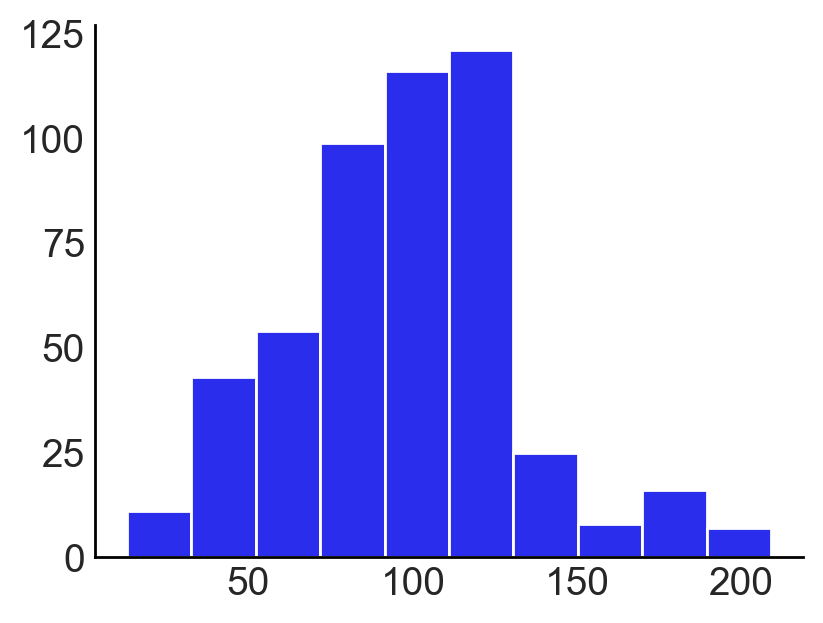

In [34]:
# Plot noisy observed network 
# DG_noise = nx.from_numpy_array(obs_mat)
# nx.draw(DG_noise, with_labels=True,  node_color = Z)
# plt.show()
plt.figure(figsize=(4,3))
print(np.mean(np.sum(obs_mat,1)))
plt.hist(np.sum(obs_mat,1))

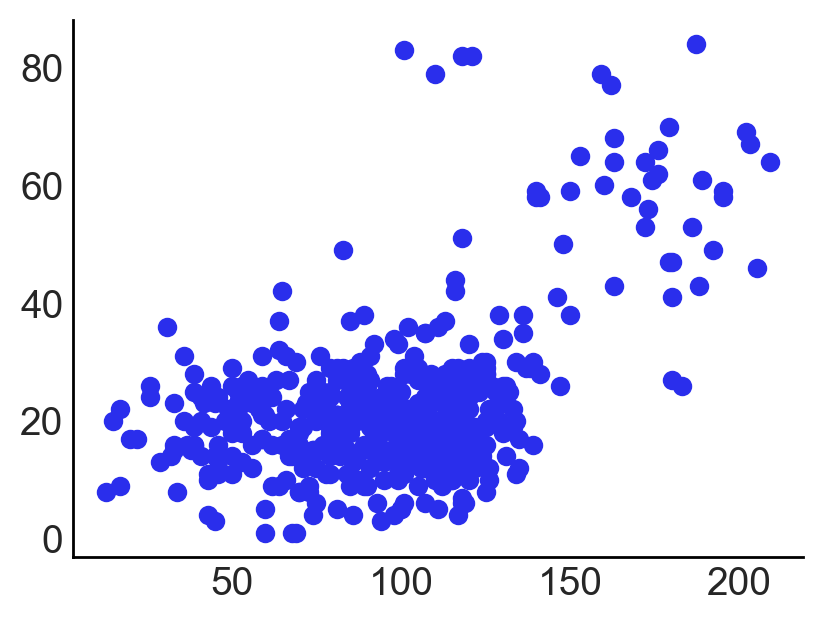

In [35]:
plt.figure(figsize=(4,3))
plt.scatter(np.sum(obs_mat,1), np.sum(mat,1))

In [36]:
trils_pd = pd.DataFrame({'true' : triu_vals, 'obs' : triu_obs})
print(pd.crosstab(index=trils_pd['true'], columns=trils_pd['obs']))


obs     0.0    1.0
true              
0.0   98880  20097
1.0    1437   4336


                0
count  500.000000
mean     2.310149
std      1.016747
min      0.219839
25%      1.532456
50%      2.360142
75%      3.071554
max      5.106369
Corr obs~true exposures:  0.3072264252064113
Corr obs~true Zeigen:  0.20768862021717457
Corr true_zeigen~Y :  0.4210916341545442
Corr obs_zeigen~Y :  0.11301916218999336


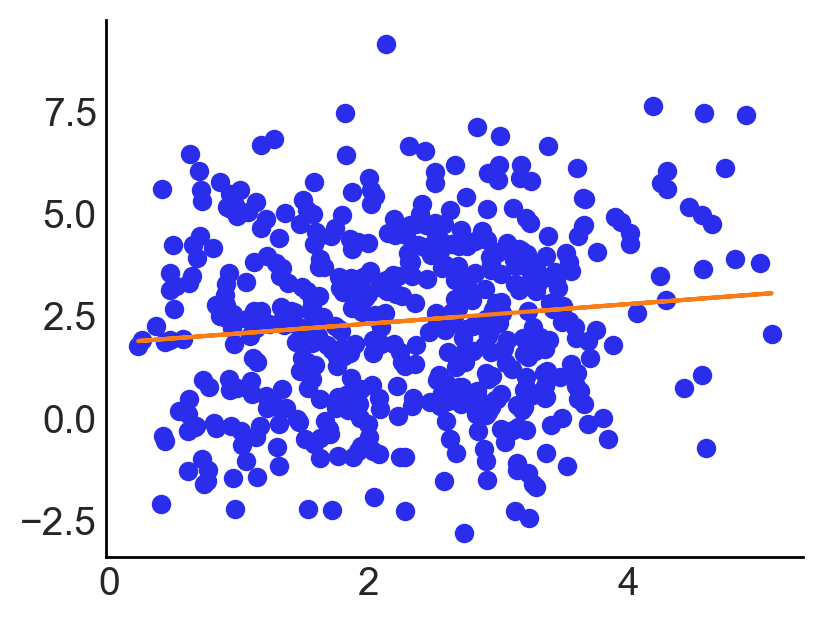

In [37]:
 
# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1) > 0.5
# # obs_exposures = np.dot(obs_mat,Z)
# obs_exposures = np.dot(obs_mat,Z)


# obs_net = nx.from_numpy_array(obs_mat)
# obs_deg = np.array([degree for _, degree in obs_net.degree()])
# obs_betweeness = np.array(list(nx.betweenness_centrality(obs_net).values()))
# obs_triangles = np.array(list(nx.triangles(obs_net).values()))
# obs_eigen_center = np.array(list(nx.eigenvector_centrality_numpy(obs_net).values()))
obs_degrees = np.sum(obs_mat,1)
obs_eigen_cent = eigen_centrality(obs_mat)
obs_exposures = np.dot(obs_mat,Z) / obs_degrees
# obs_Zeigen = np.dot(obs_mat, Z*obs_eigen_cent)
obs_Zeigen = zeigen_value(Z, obs_eigen_cent, obs_mat)

# obs_df = np.transpose(np.array([[1]*n, Z, obs_exposures,x, obs_eigen_center, obs_betweeness]))
# obs_df = np.transpose(np.array([[1]*n, Z, x, obs_Zeigen, obs_exposures]))

# obs_df = np.transpose(np.array([[1]*n, Z, x, x2, obs_Zeigen]))
obs_df = np.transpose(np.array([[1]*n, Z, x, Z*x, obs_Zeigen]))
# obs_df = np.transpose(np.array([[1]*n, Z, obs_Zeigen]))

print(pd.DataFrame(obs_Zeigen).describe())

print("Corr obs~true exposures: ", np.corrcoef(exposures, obs_exposures)[1,0])
print("Corr obs~true Zeigen: ", np.corrcoef(Zeigen, obs_Zeigen)[1,0])
print("Corr true_zeigen~Y : ", np.corrcoef(Zeigen, Y)[1,0])
print("Corr obs_zeigen~Y : ", np.corrcoef(obs_Zeigen, Y)[1,0])

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1)
# expos_pd = pd.DataFrame({'true' : exposures, 'obs' : obs_exposures})
# pd.crosstab(index=expos_pd['true'], columns=expos_pd['obs'])
plt.figure(figsize=(4,3))
# plt.scatter(obs_exposures,exposures, c=Z)
# plt.scatter(obs_Zeigen,Zeigen, c=x2)


plt.plot(obs_Zeigen, Y, 'o')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(obs_Zeigen, Y, 1)
#add linear regression line to scatterplot 
plt.plot(obs_Zeigen, m*obs_Zeigen+b)

# plt.scatter(obs_Zeigen,Y, c=x2)

In [38]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
data = {
    'obs_Zigen': obs_Zeigen,
    'Zeigen': Zeigen,
    'x2': x2,
    'x': x
}
df = pd.DataFrame(data)
formula = 'Zeigen ~ x2 + x'
# Fit the model
model = smf.ols(formula=formula, data=df).fit()
# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Zeigen   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     98.76
Date:                Thu, 12 Sep 2024   Prob (F-statistic):           7.71e-37
Time:                        09:42:18   Log-Likelihood:                -76.792
No. Observations:                 500   AIC:                             159.6
Df Residuals:                     497   BIC:                             172.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5299      0.013     39.359      0.0

In [39]:
print(np.corrcoef(obs_Zeigen, x2))
print(np.corrcoef(Zeigen, x2))

print(np.corrcoef(obs_Zeigen, x))
print(np.corrcoef(Zeigen, x))


[[1.         0.37220522]
 [0.37220522 1.        ]]
[[1.        0.5327337]
 [0.5327337 1.       ]]
[[1.         0.01389922]
 [0.01389922 1.        ]]
[[1.         0.03464732]
 [0.03464732 1.        ]]


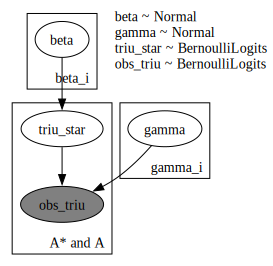

In [40]:
# NumPyro model
# def triu_to_mat(triu, n):
#     adj_mat = jnp.zeros((n,n))
#     idx_utri = np.triu_indices(n=n,k=1)
#     adj_mat = adj_mat.at[idx_utri].set(triu) 
#     return adj_mat + adj_mat.T

NN = n

@jit
def Triu_to_mat(triu_v):
    adj_mat = jnp.zeros((NN,NN))
    # idx_utri = np.triu_indices(n=NN,k=1)
    adj_mat = adj_mat.at[np.triu_indices(n=NN,k=1)].set(triu_v) 
    return adj_mat + adj_mat.T

@config_enumerate
def network_model(X, X2, TriU):
    # Network model
    # beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    # beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    with numpyro.plate("beta_i",2):
        beta = numpyro.sample("beta", dist.Normal(0,5))
    # mu_net = beta[0] + beta[1]*X + beta[2]*X2
    mu_net = beta[0] + beta[1]*X2
    # triu_n = int(n*(n-1)/2)
    
    # gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    # gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    with numpyro.plate("gamma_i",2):
        gamma = numpyro.sample("gamma", dist.Normal(0,5))
    
    # gamma0 = numpyro.sample("gamma0", dist.Beta(2,5))
    # gamma1 = numpyro.sample("gamma1", dist.Beta(2,5))
    
    with numpyro.plate("A* and A", TriU.shape[0]):
        triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_net),
                                   infer={"enumerate": "parallel"})
        # prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
        # prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        # prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*expit(gamma[0] + gamma[1]*X + gamma[2]*X2)
        # logit_misspec = triu_star*gamma[0] + (1-triu_star)*(gamma[1] + gamma[2]*X + gamma[3]*X2)
        # logit_misspec = triu_star*gamma[0] + (1-triu_star)*(gamma[1] + gamma[2]*X2)
        # logit_misspec = jnp.where(triu_star, gamma[0], gamma[1]*X)
        logit_misspec = triu_star*gamma[0] + (1-triu_star)*gamma[1]*X
        # logit_misspec = triu_star*gamma[0] + (1-triu_star)*gamma[1]
        # numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
        numpyro.sample("obs_triu", dist.Bernoulli(logits = logit_misspec), obs = TriU)
        
    # def triu_fn(carry, inp):
    #     # print("Starting tril_fn carry no.", carry)
    #     # mu_n = inp
    #     mu_n, triu_val = inp
    #     # logp of A* 
    #     # with numpyro.plate("Edges A*", triu_n):
    #     triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_n),
    #                                infer={"enumerate": "parallel"})
    #     # print("Triu_Star shape (within) is", triu_star.shape)
    #     # # logp of A|A*
    #     # # with numpyro.plate("A|A*", 1):
    #     prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
    #     # print("prob_misspec shape is: ", prob_misspec.shape)
    #     # obs_triu_vals = numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
    #     return carry+1, triu_star  
    # 
    # sc_input = jnp.array((mu_net, TriU)).T
    # _, triu_var = scan(triu_fn, jnp.array(0), sc_input)
    # print("triu_var shape is: ", triu_var.shape)
    # scan(triu_fn, jnp.array(0), sc_input)    
    # 

@config_enumerate
# def noisy_networks_model(x_eq: jnp.ndarray, triu_v: jnp.ndarray, N_edges: int, N: int, K = 2):
def noisy_networks_model(X_diff: jnp.ndarray, X2_or: jnp.ndarray, triu_v: jnp.ndarray, N = n, K = 2):
    # True network priors
    # Latent variable for each unit from bi-normal distribution
    sigma_sq = numpyro.sample("sigma_sq", dist.InverseGamma(0.1, 1.0))
    with numpyro.plate("nu_i", N):
        nu_standard = numpyro.sample("nu_standard", dist.MultivariateNormal(loc=jnp.zeros(K), covariance_matrix=jnp.eye(K)))

    nu = numpyro.deterministic("nu", nu_standard * jnp.sqrt(sigma_sq))
    nu_diff_norm_val = latent_to_norm_of_diff(nu)

    # Save logits for A*
    with numpyro.plate("theta_dim", 2):
        theta = numpyro.sample("theta", dist.Normal(0, 5))
    mu_net = theta[0] + X2_or*theta[1] - nu_diff_norm_val

    with numpyro.plate("gamma_dim", 4):
        gamma = numpyro.sample("gamma", dist.Normal(0, 5))
   
    with numpyro.plate("A* and A", triu_v.shape[0]):
        triu_star = numpyro.sample("triu_star", dist.Bernoulli(logits=mu_net)
                                   # , infer={"enumerate": "sequential"})
                                   , infer={"enumerate": "parallel"})
        logit_misspec = jnp.where(triu_star,
                                  gamma[0],
                                  gamma[1] + gamma[2]*X_diff + gamma[3]*nu_diff_norm_val)
        numpyro.sample("obs_triu", dist.Bernoulli(logits=logit_misspec), obs=triu_v)
            
# def outcome_model(Y,Z,X,A,n):

def outcome_model(X, Y=None):
    with numpyro.plate("Lin coef.",X.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    sig = numpyro.sample("sig",dist.HalfNormal(scale=2))
    # sig = numpyro.sample("sig",dist.Exponential(0.5))
    
    # expos = jnp.dot(A,Z)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    # sum_expos = jnp.dot(A,Z)
    # deg = jnp.sum(A,1)
    # expos = jnp.where(jnp.equal(deg,0), 0, sum_expos/deg)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X 
    # mu_y = numpyro.deterministic(
    #             "mu_star",
    #              jnp.dot(X, alpha),
    # )
    # mu_y = jnp.dot(X, alpha)
    mu_y = numpyro.deterministic("mu", jnp.dot(X, alpha))
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*deg  + alpha[4]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("obs",X.shape[0]):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)
        
        
def HSGP_model(Xlin, Xgp, ell, m, Y=None, non_centered=True):
    # --- Priors ---
    magn = numpyro.sample("magn", dist.HalfNormal(2))
    length = numpyro.sample("length", dist.HalfNormal(5))
    sig = numpyro.sample("sig", dist.HalfNormal(2))
    # --- Parametrization ---
    f = numpyro.deterministic(
                  "f_star",
                  hsgp_squared_exponential(
                      x=Xgp, alpha=magn, length=length,
                      ell=ell, m=m, non_centered=non_centered
              ),
    )
    with numpyro.plate("Lin coef.",Xlin.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    # mu = numpyro.deterministic("mu", jnp.dot(Xlin, alpha) + f)
    mu = numpyro.deterministic(
            "mu_star",
             jnp.dot(Xlin, alpha) + f,
    )
    # mu = beta0 + beta1*x_lin + f
    # --- Likelihood ---
    with numpyro.plate("obs", Xlin.shape[0]):
        # numpyro.sample("likelihood", dist.Normal(loc=mu, scale=noise), obs=y)
        # numpyro.sample("Y", dist.Normal(loc=f, scale=noise), obs=y)
        # numpyro.sample("Y", dist.Normal(loc=mu, scale=sig), obs=Y, sample_shape=(Xgp.shape[0],))
        numpyro.sample("Y", dist.Normal(loc=mu, scale=sig), obs=Y)
        
        
def HSGP_model_full(df1, df2, ell1, ell2, m, y=None):
        amplitude1 = numpyro.sample("amplitude1", dist.HalfNormal(2))
        length1 = numpyro.sample("lengthscale1", dist.HalfNormal(5))
        amplitude2 = numpyro.sample("amplitude2", dist.HalfNormal(2))
        length2 = numpyro.sample("lengthscale2", dist.HalfNormal(5))
        noise = numpyro.sample("noise", dist.HalfNormal(2))

        f1 = numpyro.deterministic(
            "f1_star",
            hsgp_squared_exponential(
                df1, alpha=amplitude1, length=length1, ell=ell1, m=m, i = "1"
            ),
        )
        f2 = numpyro.deterministic(
            "f2_star",
            hsgp_squared_exponential(
                df2, alpha=amplitude2, length=length2, ell=ell2, m=m, i = "2"
            ),
        )
        # intercept = numpyro.sample("intercept",dist.Normal(0,5))
        # f = numpyro.deterministic("f_star", intercept + f1 + f2)
        f = numpyro.deterministic("f_star", f1 + f2)
        # site = "y" if y is not None else "y_test"
        # numpyro.sample(site, dist.Normal(f, noise), obs=y)
        numpyro.sample("Y", dist.Normal(f, noise), obs=y)
        
        
@jax.tree_util.register_pytree_node_class
class HSGPModel:
    def __init__(self, m: int, L1: float | list[float | int], L2: float | list[float | int]) -> None:
        self.m = m
        self.L1 = L1
        self.L2 = L2

    def model(
        self,
        df1: jax.Array,
        df2: jax.Array,
        y: jax.Array | None = None,
    ):
        amplitude1 = numpyro.sample("amplitude1", dist.HalfNormal(2))
        length1 = numpyro.sample("lengthscale1", dist.HalfNormal(5))
        amplitude2 = numpyro.sample("amplitude2", dist.HalfNormal(2))
        length2 = numpyro.sample("lengthscale2", dist.HalfNormal(5))
        noise = numpyro.sample("noise", dist.HalfNormal(2))

        # f = numpyro.deterministic(
        #     "f_star",
        #     hsgp_squared_exponential(
        #         df1, alpha=amplitude1, length=length1, ell=self.L1, m=self.m
        #     ),
        # )
        # f1 = hsgp_squared_exponential(
        #         df1, alpha=amplitude1, length=length1, ell=self.L1, m=self.m, i=str(1)
        #     )
        # 
        # f2 = hsgp_squared_exponential(
        #         df2, alpha=amplitude2, length=length2, ell=self.L2, m=self.m, i=str(2)
        #     )
        
        f1 = numpyro.deterministic(
            "f1_star",
            hsgp_squared_exponential(
                df1, alpha=amplitude1, length=length1, ell=self.L1, m=self.m, i=str(1)
            ),
        )        
        f2 = numpyro.deterministic(
            "f2_star",
            hsgp_squared_exponential(
                df2, alpha=amplitude2, length=length2, ell=self.L2, m=self.m, i=str(2)
            ),
        )
        # intercept = numpyro.sample("intercept",dist.Normal(0,5))
        f = numpyro.deterministic("f_star", f1 + f2)
        # f = numpyro.deterministic("f_star", intercept + f1 + f2)
        site = "y" if y is not None else "y_test"
        numpyro.sample(site, dist.Normal(f, noise), obs=y)
        # numpyro.sample(site, dist.Normal(f1 + f2 + intercept, noise), obs=y)

    def tree_flatten(self):
        children = ()  # arrays / dynamic values
        aux_data = (
            self.L1,
            self.L2,
            self.m,
        )  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)
        
        
# numpyro.render_model(model, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)
numpyro.render_model(network_model, model_args=(x_diff, x2_or ,triu_obs), render_distributions=True)
# numpyro.render_model(model, model_args=(Y,Z,x_diff,tril_vals))

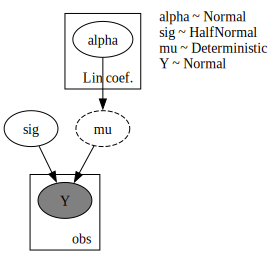

In [41]:
# numpyro.render_model(outcome_model, model_args=(Y,Z,x,mat,n), render_distributions=True)

df_array = jnp.array(df_array)
Y = jnp.array(Y)

numpyro.render_model(outcome_model, model_args=(df_array,Y), render_distributions=True)

In [42]:
c = 3
# c = 3.5

# Xgp = jnp.array(df_array[:,2:])
Xgp = jnp.array(df_array[:,3:])
# Xgp = jnp.array(df_array[:,4:])
# Xlin = jnp.array(df_array[:,0:4])
Xlin = jnp.array(df_array[:,0:3])
# Xlin = jnp.array(df_array[:,0:2])

# ell = 3.5*np.max(np.abs(df_array[:,3:]))
ell = jnp.array(c*np.max(np.abs(Xgp))).reshape((1,1))
# m = 20
# m = 20
m = 15
# m = 50



# numpyro.render_model(HSGP_model, model_args=(Xgp, Xlin, ell, m, Y), render_distributions=True)

In [ ]:
# A* and A|A* models

rng_key = random.PRNGKey(1)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))  
# kernel = NUTS(model, dense_mass=True)
# kernel_network = NUTS(network_model, dense_mass=[("gamma","beta")], max_tree_depth=15)
# kernel_network = NUTS(network_model)
kernel_network = NUTS(network_model, init_strategy=numpyro.infer.init_to_median(num_samples=30))
# kernel_network = NUTS(network_model, 
                      # init_strategy=numpyro.infer.init_to_value(values={"beta": jnp.array([0.0,0.0,0.0]),"gamma" : jnp.array([0.0, 0.0])}))
mcmc_network = MCMC(kernel_network, num_warmup=1000, num_samples=1000,num_chains=4)
# mcmc_network = MCMC(kernel_network, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_,X=x_diff,X2  = x2_or, TriU=triu_obs)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

In [ ]:
# A* and A|A* models + latent U

rng_key = random.PRNGKey(1)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))  
# kernel = NUTS(model, dense_mass=True)
# kernel_network = NUTS(network_model, dense_mass=[("gamma","beta")], max_tree_depth=15)
# kernel_network = NUTS(network_model)
kernel_network = NUTS(noisy_networks_model, init_strategy=numpyro.infer.init_to_median(num_samples=30), target_accept_prob=0.95)
# kernel_network = NUTS(network_model, 
                      # init_strategy=numpyro.infer.init_to_value(values={"beta": jnp.array([0.0,0.0,0.0]),"gamma" : jnp.array([0.0, 0.0])}))
mcmc_network = MCMC(kernel_network, num_warmup=200, num_samples=500,num_chains=4)
# mcmc_network = MCMC(kernel_network, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_, X_diff=x_diff, X2_or = x2_or, triu_v=triu_obs)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

In [ ]:
@jit
def Astar_pred(key, post_samples, Xd, triu):
    # if mean_post:
    pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True,num_samples=1)
    # else:
    #     pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True)
    return pred_func(key, X=Xd, TriU=triu)
        

In [43]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, autoguide, config_enumerate, infer_discrete
import torch
from pyro import poutine
from scipy.linalg import orthogonal_procrustes

def cosine_similarity_torch(X):
    # Normalize the rows
    X_normalized = X / torch.linalg.norm(X, dim=1, keepdim=True)
    
    # Compute dot products for upper triangle
    n = X.shape[0]
    triu_indices = torch.triu_indices(n, n, offset=1)
    dot_products = torch.mm(X_normalized, X_normalized.T)[triu_indices[0], triu_indices[1]]
    
    return dot_products


def orthogonal_transform(reference, target):
    target = target.detach().numpy()
    reference = reference.detach().numpy()
    R, _ = orthogonal_procrustes(target, reference)
    transformed = torch.tensor(target @ R, dtype=torch.float32)
    return transformed

@config_enumerate
# @infer_discrete(first_available_dim=-2)
def pyro_noisy_networks_model(x, x2, triu_v, N, K=2, eps = 1e-3):
    # sigma_sq = pyro.sample("sigma_sq", dist.InverseGamma(0.1, 1.0))
    # sigma_sq = pyro.sample("sigma_sq", dist.LogNormal(0., 2.))
    # log_sigma_sq = pyro.sample("log_sigma_sq", dist.Normal(0, 5))
    # sigma_sq = torch.exp(log_sigma_sq)
    with pyro.plate("Latent_dim", N):
        nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(K) + eps, torch.eye(K)))
        # nu_standard = pyro.sample("nu_standard", dist.MultivariateNormal(torch.zeros(K), torch.eye(K)))
    # nu = pyro.deterministic("nu", nu_standard * torch.sqrt(sigma_sq))
    
    # nu_cosine = pyro.deterministic("nu_cosine", cosine_similarity_torch(nu))
    
    idx = torch.triu_indices(N, N, offset=1)
    nu_diff = nu[idx[0]] - nu[idx[1]]
    nu_diff_norm_val = torch.norm(nu_diff, dim=1)
    # 
    with pyro.plate("theta_dim", 2):
        theta = pyro.sample("theta", dist.Normal(0, 5))
   
    mu_net = theta[0] + x2*theta[1] - nu_diff_norm_val
    # mu_net = theta[0] + x2*theta[1] + nu_cosine
    # mu_net = theta[0] + x2*theta[1] 
    mu_net = torch.clamp(mu_net, min=-30, max=30)
    
    with pyro.plate("gamma_i", 4):
        gamma = pyro.sample("gamma", dist.Normal(0, 5))
   
    with pyro.plate("A* and A", x.shape[0]):
        triu_star = pyro.sample("triu_star", dist.Bernoulli(logits=mu_net),
                                infer={"enumerate": "parallel"})

        logit_misspec = torch.where(triu_star==1.0,
                                    gamma[0],
                                    gamma[1] + gamma[2]*x + gamma[3]*x2)
                                    # gamma[1] + gamma[2]*x)
                                    # gamma[1] + gamma[2]*x + gamma[3]*nu_diff_norm_val)

        pyro.sample("obs_triu", dist.Bernoulli(logits=logit_misspec), obs=triu_v)



100%|██████████| 10000/10000 [11:27<00:00, 14.55it/s]


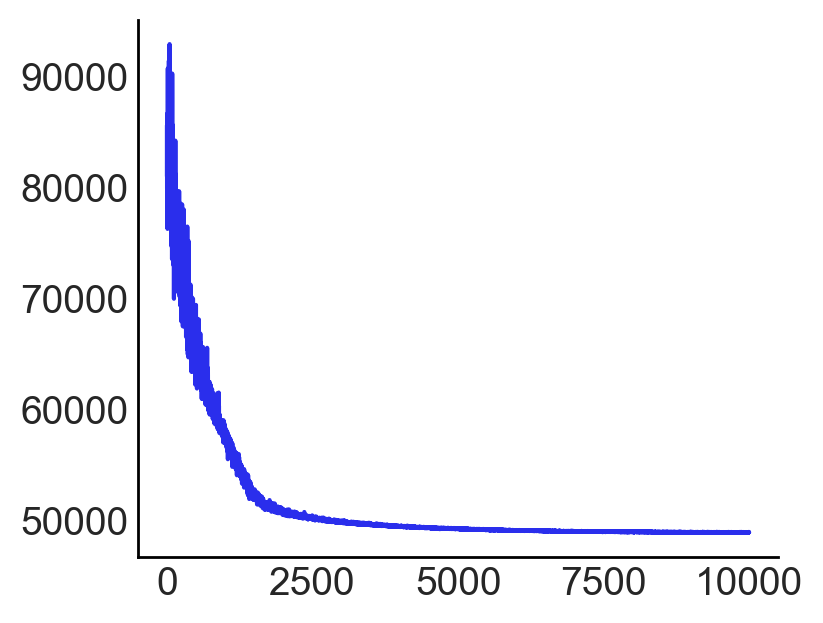

In [44]:
# Run full model with reference nu

pyro.clear_param_store()

# guide = autoguide.AutoMultivariateNormal(poutine.block(pyro_noisy_networks_model, hide=["triu_star"]),
#                                          init_loc_fn=autoguide.init_to_median())

guide = autoguide.AutoLowRankMultivariateNormal(poutine.block(pyro_noisy_networks_model, hide=["triu_star"]),
                                      # init_loc_fn=autoguide.init_to_value(values = {"nu_standard": nu_init, 'log_sigma_sq' : guide_init.nodes['log_sigma_sq']['value'],
                                      #                                               'theta': guide_init.nodes['theta']['value'], 'gamma': guide_init.nodes['gamma']['value']},
                                      #                                     fallback=autoguide.init_to_median())) 
                                        init_loc_fn = autoguide.init_to_median())

# guide_init = autoguide.AutoNormal(poutine.block(pyro_noisy_networks_model, hide=["triu_star"]),
#                                       init_loc_fn=autoguide.init_to_median()) 

# guide = autoguide.AutoNormal(poutine.block(pyro_noisy_networks_model_wref, hide=["triu_star"]),
#                                          init_loc_fn=autoguide.init_to_value(values=map_posterior_params))
# max_plate_nesting = 1 because there is a single plate in the model
loss_func = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)
# loss_func = pyro.infer.discrete.TraceEnumSample_ELBO(max_plate_nesting=1)

tt_x_diff = torch.tensor(np.array(x_diff), dtype=torch.float32)
tt_x2_or = torch.tensor(np.array(x2_or), dtype=torch.float32)
tt_triu_obs = torch.tensor(triu_obs, dtype=torch.float32)

optimzer = pyro.optim.ClippedAdam({"lr": 0.001})
# optimzer = pyro.optim.Adam({"lr": 0.001})

# svi = SVI(pyro_noisy_networks_model_wref, guide, optimzer, loss=loss_func)
svi_full = SVI(pyro_noisy_networks_model, guide, optimzer, loss=loss_func)
losses_full = []
for _ in tqdm(range(10000)):
    loss = svi_full.step(tt_x_diff, tt_x2_or, tt_triu_obs, n)
    # loss = svi.step(tt_x_diff, tt_x2_or, tt_triu_obs, n, nu_ref)
    losses_full.append(loss)
plt.figure(figsize=(4,3))
plt.plot(losses_full)
plt.show()
posterior_params_full = {k: np.array(v.data) for k, v in pyro.get_param_store().items()}

In [47]:
# guide_trace = poutine.trace(guide).get_trace(tt_x_diff, tt_x2_or, tt_triu_obs)
# inferred_model = infer_discrete(poutine.replay(pyro_noisy_networks_model, guide_trace), first_available_dim=-2)
# model_trace = poutine.trace(inferred_model).get_trace(tt_x_diff, tt_x2_or, tt_triu_obs)
# model_trace.nodes['triu_star']['value'].shape

num_samples = 1000
triu_star_sample = []
nu_samples = []
for _ in tqdm(range(num_samples), desc="Triu samples"):
    # Get a trace from the guide
    guide_trace = poutine.trace(guide).get_trace(tt_x_diff, tt_x2_or, tt_triu_obs, n)
    # Run infer_discrete
    inferred_model = infer_discrete(poutine.replay(pyro_noisy_networks_model, guide_trace), first_available_dim=-2)
    # Get a trace from the inferred model
    model_trace = poutine.trace(inferred_model).get_trace(tt_x_diff, tt_x2_or, tt_triu_obs, n)
    # Extract triu_star from the trace
    triu_star_sample.append(model_trace.nodes['triu_star']['value'])
    # Extract nu from the trace
    nu_samples.append(model_trace.nodes['nu']['value'])

# Convert to tensor
triu_star_samples = torch.stack(triu_star_sample)
nu_samples = torch.stack(nu_samples)
print(triu_star_samples.shape, nu_samples.shape)

Triu samples: 100%|██████████| 1000/1000 [00:52<00:00, 19.03it/s]


torch.Size([1000, 124750]) torch.Size([1000, 500, 2])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([124750])


100%|██████████| 1000/1000 [00:25<00:00, 38.90it/s]


(1000, 500) (1000, 500) <class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>
MAE: 0.60407835
MAE: 1.7321616


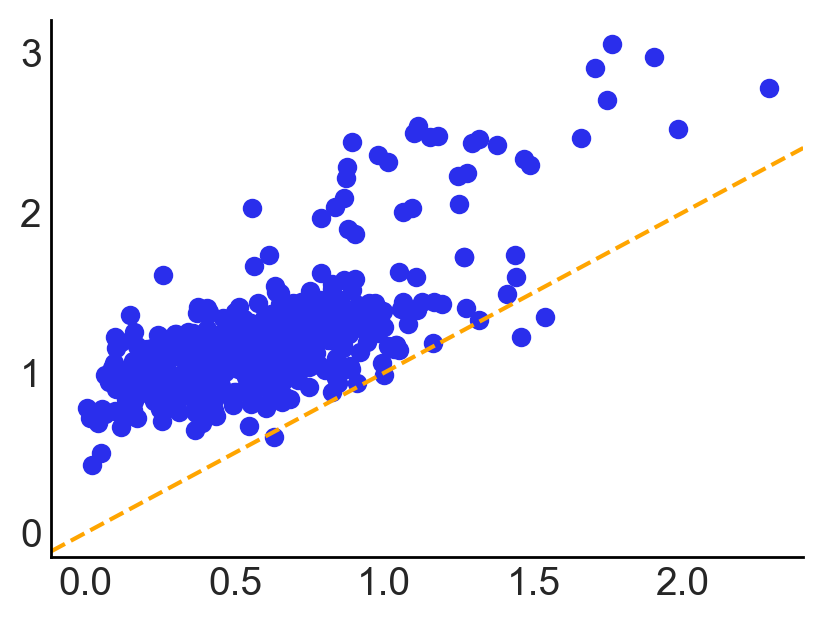

In [48]:
def triu_to_mat(triu_values, N):
    """
    Convert upper triangular values to a full adjacency matrix.
    
    Parameters:
    triu_values (torch.Tensor): Upper triangular values, shape (num_triu_elements,)
    N (int): Number of nodes in the network
    
    Returns:
    torch.Tensor: Full adjacency matrix, shape (N, N)
    """
    # Create an empty N x N matrix
    adj_matrix = torch.zeros((N, N), dtype=triu_values.dtype)
    
    # Get the indices for the upper triangular part
    triu_indices = torch.triu_indices(N, N, offset=1)
    
    # Fill the upper triangular part
    adj_matrix[triu_indices[0], triu_indices[1]] = triu_values
    
    # Make the matrix symmetric by adding its transpose
    adj_matrix = adj_matrix + adj_matrix.T
    
    return adj_matrix

# degs_post = torch.zeros(n, dtype=triu_star_samples.dtype)
# degs_post = torch.zeros(n, dtype=samples['obs_triu'].dtype)
# degs_post = jnp.zeros(n)
z_samp = rng.binomial(n=1, p=.6, size=n)
post_stat = []
zeigen_new = []
for i in tqdm(range(num_samples)):
    cur_triu_star = triu_star_samples[i]
    # cur_triu_star = samples['obs_triu'][i]
    if i == 0:
        print(cur_triu_star.shape)
    # cur_mat_star = triu_to_mat(cur_triu_star, n)
    cur_mat_star = Triu_to_mat(jnp.array(cur_triu_star))
    eig_cen = eigen_centrality(cur_mat_star)
    cur_zeig = zeigen_value(Z, eig_cen, cur_mat_star)
    zeig_new = zeigen_value(z_samp, eig_cen, mat)
    # cur_deg = cur_mat_star.sum(dim=1)
    # cur_deg = jnp.sum(cur_mat_star, 1)
    # degs_post += cur_deg
    # degs_post += cur_zeig
    post_stat.append(cur_zeig)
    zeigen_new.append(zeig_new)
    
# avg_deg_post = degs_post / num_samples
# avg_deg_post = avg_deg_post.cpu().numpy()
post_stat = jnp.array(post_stat)
zeigen_new = jnp.array(zeigen_new)
print(post_stat.shape, zeigen_new.shape, type(post_stat), type(zeigen_new))
avg_zeigen = post_stat.mean(axis=0)
# true_deg = np.sum(mat,1)
# print("MAPE:", np.mean(np.abs(avg_deg_post - Zeigen)))
print("MAE:", np.mean(np.abs((avg_zeigen - Zeigen))))
print("MAE:", np.mean(np.abs((obs_Zeigen - Zeigen))))
# print("MAPE:", np.mean(np.abs((avg_deg_post - true_deg)/true_deg)))
# print("MAPE:", np.mean(np.abs((avg_deg_post - np.sum(obs_mat,1))/np.sum(obs_mat,1))))
# print("MAPE:", np.mean(np.abs(avg_deg_post - np.sum(mat,1))))
plt.figure(figsize=(4,3))
# plt.scatter(true_deg, avg_deg_post)
# plt.scatter(np.sum(mat,1), avg_deg_post)
plt.scatter(Zeigen, avg_zeigen)
plt.axline((0, 0), slope=1, color="orange", linestyle="--")   



In [50]:
print(np.corrcoef(Zeigen, avg_zeigen), '\n',
      np.corrcoef(obs_Zeigen, Zeigen), '\n',
      np.corrcoef(x2, Zeigen), '\n',
      np.corrcoef(x2, obs_Zeigen), '\n',
      np.corrcoef(x2, avg_zeigen))

[[1.         0.72746779]
 [0.72746779 1.        ]] 
 [[1.         0.20768862]
 [0.20768862 1.        ]] 
 [[1.        0.5327337]
 [0.5327337 1.       ]] 
 [[1.         0.37220522]
 [0.37220522 1.        ]] 
 [[1.         0.75958955]
 [0.75958955 1.        ]]


In [ ]:
test_mat = triu_to_mat(triu_star_samples[5], n).cpu().numpy()
plt.figure(figsize=(4,3))
plt.scatter(np.sum(mat,1), np.sum(test_mat,1))
plt.axline((0, 0), slope=1, color="orange", linestyle="--")   


In [ ]:
# plt.scatter(samples['nu'].mean(axis=0)[0], samples['nu'].mean(axis=0)[0,1])
# plt.scatter(samples['nu'].mean(axis=0)[0,:,0], samples['nu'].mean(axis=0)[0,:,1])
# plt.scatter(samples['nu'].mean(axis=0)[0,:,0], U_latent[:,0])
# plt.scatter(samples['nu'].mean(axis=0)[0,:,1], U_latent[:,1])

from scipy.linalg import orthogonal_procrustes
from scipy.spatial import procrustes

def procrustes_alignment(posterior_draws):
    """
    Perform Procrustes alignment on multiple posterior draws of U_i.
    
    :param posterior_draws: List of numpy arrays, each of shape (N, 2), where N is the number of units
    :return: List of aligned posterior draws
    """
    # Calculate the mean configuration as the reference
    mean_config = np.mean(posterior_draws, axis=0)
    # mean_config = posterior_draws[0]
    
    # Initialize array for aligned draws
    aligned_draws = np.zeros_like(posterior_draws)

    # Align each draw to the mean configuration
    for i in range(posterior_draws.shape[0]):
        # _, transformed, _ = procrustes(mean_config, posterior_draws[i])
        # # transformed, _ = orthogonal_procrustes(mean_config, posterior_draws[i])
        # aligned_draws[i] = transformed
        R, _ = orthogonal_procrustes(posterior_draws[i], mean_config)
        transformed_nu = posterior_draws[i] @ R
        aligned_draws[i] = transformed_nu
    # aligned_draws = orthogonal_procrustes()    
    return aligned_draws

aligned_nu = procrustes_alignment(nu_samples.detach().numpy())
print(aligned_nu.shape)
plt.figure(figsize=(4,3))
plt.scatter(U_diff_norm_val, latent_to_norm_of_diff(np.mean(aligned_nu,axis=0)))
# print(np.corrcoef(U_diff_norm_val, latent_to_norm_of_diff(np.mean(nu_samples.detach().numpy(),axis=0))))
print(np.corrcoef(U_diff_norm_val, latent_to_norm_of_diff(np.mean(aligned_nu,axis=0))))
# plt.scatter(U_diff_norm_val, latent_to_norm_of_diff(np.mean(nu_samples.detach().numpy(),axis=0)))

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# ax1.scatter(U_latent[:,1], np.mean(aligned_nu,axis=0)[:,1])
# ax1.scatter(np.mean(aligned_nu,axis=0)[:,0], np.mean(aligned_nu,axis=0)[:,1])
# ax1.scatter(np.mean(nu_samples.detach().numpy(),axis=0)[:,0], np.mean(nu_samples.detach().numpy(),axis=0)[:,1])
# ax1.scatter(nu_ref.detach().numpy()[:,0], nu_ref.detach().numpy()[:,1])
# ax2.scatter(U_latent[:,0], U_latent[:,1])
plt.scatter(U_latent[:,1],  np.mean(aligned_nu,axis=0)[:,1])
# print(np.corrcoef(U_latent[:,0], samples['nu'].mean(axis=0)[0,:,0]))
print(np.corrcoef(U_latent[:,1], np.mean(aligned_nu,axis=0)[:,1]))

In [ ]:
# Pyro GP outcome model
import pyro.contrib.gp as gp
from torch.multiprocessing import Pool, cpu_count
from torch.utils.data import TensorDataset, DataLoader
from sklearn.cluster import KMeans

# os.environ['OMP_NUM_THREADS'] = 2

# def kmeans_selection(X, num_inducing):
#     # Convert to numpy for sklearn
#     X_np = X.cpu().numpy()
#     # Perform K-means clustering
#     kmeans = KMeans(n_clusters=num_inducing, random_state=0, n_init=10)
#     kmeans.fit(X_np)
#     # Convert cluster centers back to torch tensor
#     Xu = torch.tensor(kmeans.cluster_centers_, dtype=X.dtype)
#     return Xu

df_gp = torch.stack([torch.tensor(Z), torch.from_numpy(np.array(Zeigen)), torch.tensor(x)], dim=1)
Y_gp = torch.from_numpy(np.array(Y))

# Ensure consistent dtype
# dtype = torch.float64

# Convert your data to the specified dtype
# df_gp = df_gp.to(dtype)
# Y_gp = Y_gp.to(dtype)

dataset = TensorDataset(df_gp, Y_gp)
batch_size = n//2  # Adjust based on your dataset size and available memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Initialize inducing points with K-means
# num_inducing = 100  # Adjust as needed
# Xu_init = kmeans_selection(df_gp, num_inducing)

# Clear any existing parameters
pyro.clear_param_store()

# Set up the kernel
kernel = gp.kernels.RBF(input_dim=3, variance=torch.tensor(2.0), lengthscale=torch.tensor(3.0))

# Set up the GP model
# gpr = gp.models.GPRegression(df_gp, Y_gp, kernel, noise=torch.tensor(1.0))
gpr = gp.models.GPRegression(df_gp[:1], Y_gp[:1], kernel, noise=torch.tensor(1.0))
# sgpr = gp.models.SparseGPRegression(df_gp[:1], Y_gp[:1], kernel, Xu=Xu_init, jitter=1e-5)

# sgpr.Xu.requires_grad = True

# Define priors on the hyperparameters
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 3.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
gpr.noise = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
# sgpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 3.0))
# sgpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
# sgpr.noise = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))


# Set up the optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(sgpr.parameters(), lr=0.005)
# optimizer = torch.optim.Adam([
#     {'params': sgpr.parameters(), 'lr': 0.01},
#     {'params': sgpr.Xu, 'lr': 0.001}  # Separate learning rate for inducing points
# ])

loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

# Training loop
# num_steps = 3000
# losses = []
# for i in tqdm(range(num_steps)):
#     optimizer.zero_grad()
#     loss = loss_fn(gpr.model, gpr.guide)
#     # loss = compute_loss(gpr.model, gpr.guide)
#     loss.backward()
#     optimizer.step()
#     losses.append(loss.item())
# 

# # Training loop
num_epochs = 5000  # Adjust as needed
losses = []
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        # Update the model's data for this batch
        gpr.set_data(batch_X, batch_y)
        loss = loss_fn(gpr.model, gpr.guide)
        # sgpr.set_data(batch_X, batch_y)
        # loss = loss_fn(sgpr.model, sgpr.guide)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    # print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
# 
# # After training, set the model back to use all data
gpr.set_data(df_gp, Y_gp)
# sgpr.set_data(df_gp, Y_gp)

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)

In [ ]:
def robust_cholesky(matrix, max_tries=5, initial_jitter=1e-6):
    jitter = initial_jitter
    num_tries = 0
    while num_tries < max_tries:
        try:
            L = torch.linalg.cholesky(matrix + torch.eye(matrix.shape[0]) * jitter)
            print("num_tries = ", num_tries)
            return L
        except RuntimeError:
            jitter *= 10
            num_tries += 1
    raise ValueError(f"Matrix is not positive definite, even with jitter of {jitter}")

def predict(gpr, X_new, num_samples=5000, approx=True):
    with torch.no_grad():
        # mean, cov = gpr(X_new, full_cov=True, noiseless=False)
        mean, cov = gpr(X_new, full_cov=True, noiseless=True)
        if approx:
            # Add small jitter to ensure positive definiteness
            # jitter = torch.eye(cov.shape[0]) * 1e-6
            # L = torch.linalg.cholesky(cov + jitter)
            L = robust_cholesky(cov)
            # Generate samples from standard normal distribution
            eps = torch.randn(cov.shape[0], num_samples, dtype=torch.float64)
            # Transform to samples from multivariate normal
            samples = mean.unsqueeze(1) + L @ eps
            return mean,cov,samples.T
        else:
            samples = dist.MultivariateNormal(mean, cov).sample(sample_shape=(num_samples,))
            return mean,cov,samples


# pred_mean, pred_cov, pred_samples = predict(gpr, df_gp)
pred_mean_ap, pred_cov_ap, pred_samples_ap = predict(gpr, df_gp, approx=True)
# pred_mean, pred_cov, pred_samples = predict(sgpr, df_gp)
# print(pred_mean.shape, pred_cov.shape, pred_samples.shape)
print(pred_mean_ap.shape, pred_cov_ap.shape, pred_samples_ap.shape)


In [ ]:
pred_train_np = pred_samples_ap.detach().numpy()
# pred_train_np = pred_samples_ap.detach().numpy()
# print(np.std(pred_train_np, axis=0))
q025, q975 = np.percentile(pred_train_np, [2.5, 97.5], axis=0)
ind_cover = np.mean(((Y-epsilon) > q025) & ((Y-epsilon) < q975))
ind_cover

In [ ]:
plt.figure(figsize=(4,3))
# pred_mean_np = pred_mean.detach().numpy()
pred_mean_np = pred_train_np.mean(axis=0)
print("MAE:", np.mean(np.abs((pred_mean_np - np.array(Y-epsilon)))))
plt.errorbar(Y-epsilon, pred_mean_np, yerr=[pred_mean_np-q025, q975-pred_mean_np], 
             fmt='o', capsize=3, capthick=.6, ecolor='gray', alpha=0.8)
# plt.scatter(Y-epsilon, pred_mean_np)
# plt.scatter(Y, q975)
# plt.fill_between(Y, q025, q975, alpha=0.5)
plt.axline((0, 0), slope=1, color="orange", linestyle="--")   

# TODO: continue here to check prediction on X_test (new z and zeigen) and with SparseGP

In [ ]:
z_samp = rng.binomial(n=1, p=.3, size=n)
zeigen_sample = zeigen_value(z_samp, eigen_center, mat)
df_gp_new = torch.stack([torch.tensor(z_samp), torch.from_numpy(np.array(zeigen_sample)), torch.tensor(x)], dim=1)
y_samp, eps = gen_y(z_samp, x, zeigen_sample, alpha, lin=False)
samp_esti = y_samp - eps
Y_gp_new = torch.from_numpy(np.array(y_samp))

pred_mean_new, pred_cov_new, pred_samples_new = predict(gpr, df_gp_new)

pred_test_np = pred_samples_new.detach().numpy()
# print(np.std(pred_train_np, axis=0))
q025_test, q975_test = np.percentile(pred_test_np, [2.5, 97.5], axis=0)
ind_cover_test = np.mean((samp_esti > q025_test) & (samp_esti < q975_test))
# ind_cover_test = np.mean((y_samp > q025_test) & (y_samp < q975_test))
print("pted shape:", pred_samples_new.shape)
print("Test cover:", ind_cover_test)

pred_mean_test = pred_test_np.mean(axis=0)
plt.figure(figsize=(4,3))
print("MAE:", np.mean(np.abs((pred_mean_test - samp_esti))))
plt.errorbar(samp_esti, pred_mean_test, yerr=[pred_mean_test-q025_test, q975_test-pred_mean_test], 
             fmt='o', capsize=3, capthick=.6, ecolor='gray', alpha=0.8)
# plt.scatter(samp_esti, pred_mean_test)
# plt.scatter(Y, q975)
# plt.fill_between(Y, q025, q975, alpha=0.5)
plt.axline((0, 0), slope=1, color="orange", linestyle="--") 

# TODO: GP works well on test set as well.  Check how SVI network module (LSM) works for data analysis (e.g., do predictive posterior checks for A obs for one school)

In [ ]:
z_samp = rng.binomial(n=1, p=0.8, size=n)
zeigen_sample = zeigen_value(z_samp, eigen_center, mat)
df_gp_new = torch.stack([torch.tensor(z_samp), torch.from_numpy(np.array(zeigen_sample)), torch.tensor(x)], dim=1)

z_samp2 = rng.binomial(n=1, p=0.6, size=n)
zeigen_sample2 = zeigen_value(z_samp2, eigen_center, mat)
df_gp_new2 = torch.stack([torch.tensor(z_samp2), torch.from_numpy(np.array(zeigen_sample2)), torch.tensor(x)], dim=1)

z_new = torch.tensor(np.array([z_samp, z_samp2]))
zeigen_new = torch.tensor(np.array([zeigen_sample, zeigen_sample2]))
print(z_new.shape, zeigen_new.shape, z_new.ndim, z_samp.ndim)
n_z = z_new.shape[0]
df_new = torch.stack([z_new, zeigen_new, torch.tensor(x).repeat(n_z, 1)], dim=2)
print(df_new.shape)
print(df_new[0].shape, df_gp.shape)
samples_multi = []
for i in range(n_z):
    pred_mean_new, pred_cov_new, pred_samples_new = predict(gpr, df_new[i])
    samples_multi.append(pred_samples_new)

# samples_multi = torch.stack(samples_multi)
samples_multi = jnp.array(samples_multi)
# with torch.no_grad():
#         mean, cov = gpr(df_new, full_cov=True, noiseless=False)
#         samples = dist.MultivariateNormal(mean, cov).sample(sample_shape=(168,))
# 
print(samples_multi.shape, samples_multi.mean(axis=0).shape)


In [ ]:
from jax2torch import jax2torch
import torch.multiprocessing as mp
# import multiprocessing
# from functools import partial
from joblib import Parallel, delayed

class Outcome_GP:
    def __init__(self, X, Y, Z, Zeigen, n_iter = 1000, n_samples = 100):
        self.X = torch.from_numpy(np.array(X))
        # self.X = jax2torch(lambda x: x)(X)
        # self.X2 = torch.tensor(X2)
        self.Y = torch.from_numpy(np.array(Y))
        # self.Y = jax2torch(lambda x: x)(Y)
        # self.Z = jax2torch(lambda x: x)(Z)
        self.Z = torch.from_numpy(np.array(Z))
        # self.adj_mat = data["adj_mat"]
        # self.eig_cen = eigen_centrality(self.adj_mat)
        # self.zeigen = torch.from_numpy(np.array(zeigen_value(self.Z, self.eig_cen, self.adj_mat)))
        # self.zeigen = jax2torch(lambda x: x)(Zeigen)
        self.zeigen = torch.from_numpy(np.array(Zeigen))
        self.n = n
        self.df = self.get_df()
        self.gpr = self.gpr_model()
        # self.rng_key = rng_key
        self.n_iter = n_iter
        self.n_samples = n_samples
        self.dataset = TensorDataset(self.df, self.Y)
        self.batch_size = self.n // 2  # Adjust based on your dataset size and available memory
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
        self.post_samples = None


    def get_df(self):
        return torch.stack([self.Z, self.zeigen, self.X], dim=1)
        # return torch.stack([torch.tensor(self.Z), self.zeigen, self.X], dim=1)

    def gpr_model(self):
        kernel = gp.kernels.RBF(input_dim=3, variance=torch.tensor(2.0), lengthscale=torch.tensor(3.0))
        # return gp.models.GPRegression(self.df, self.Y, kernel, noise=torch.tensor(1.0))
        return gp.models.GPRegression(self.df[:1], self.Y[:1], kernel, noise=torch.tensor(1.0))

    def train_model(self):
        pyro.clear_param_store()
        # Define priors on the hyperparameters
        self.gpr.kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(0.0, 3.0))
        self.gpr.kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(0.0, 2.0))
        self.gpr.noise = pyro.nn.PyroSample(pyro.distributions.LogNormal(0.0, 1.0))
        # Set up the optimizer
        optimizer = torch.optim.Adam(self.gpr.parameters(), lr=0.01)
        loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
        # Training loop
        # losses = []
        for epoch in range(self.n_iter):
            # epoch_loss = 0
            for batch_X, batch_y in self.dataloader:
                optimizer.zero_grad()
                # Update the model's data for this batch
                self.gpr.set_data(batch_X, batch_y)
                loss = loss_fn(self.gpr.model, self.gpr.guide)
                # sgpr.set_data(batch_X, batch_y)
                # loss = loss_fn(sgpr.model, sgpr.guide)
                loss.backward()
                optimizer.step()
                # epoch_loss += loss.item()
            # avg_loss = epoch_loss / len(dataloader)
            # losses.append(avg_loss)
            # print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        # 
        # # After training, set the model back to use all data
        gpr.set_data(self.df, self.Y)
        # for i in tqdm(range(self.n_iter), desc="GP training"):
        #     optimizer.zero_grad()
        #     loss = loss_fn(self.gpr.model, self.gpr.guide)
        #     # loss = compute_loss(gpr.model, gpr.guide)
        #     loss.backward()
        #     optimizer.step()

    def predict_one_df(self, df):
        with torch.no_grad():
            mean, cov = self.gpr(df, full_cov=True, noiseless=False)
            # cov = cov + torch.eye(cov.shape[0]) * self.jitter
            # Add small jitter to ensure positive definiteness
            jitter = torch.eye(cov.shape[0]) * 1e-6
            L = torch.linalg.cholesky(cov + jitter)
            print("L dtype: ", L.dtype)

            # Generate samples from standard normal distribution
            eps = torch.randn(cov.shape[0], self.n_samples, dtype=torch.float64)
            print("eps dtype: ", eps.dtype)
            # Transform to samples from multivariate normal
            samples = mean.unsqueeze(1) + L @ eps

        return jnp.array(samples.T)
            # samples = pyro.distributions.MultivariateNormal(mean, cov).sample(sample_shape=(self.n_samples,))
        # return jnp.array(samples)

    def predict(self, z_new, zeigen_new):
        z_new = torch.tensor(np.array(z_new))
        zeigen_new = torch.tensor(np.array(zeigen_new))
        if z_new.ndim == 1:
            df_new = torch.stack([z_new, zeigen_new, self.X], dim=1)
            return self.predict_one_df(df_new)
        elif z_new.ndim == 2:
            n_z = z_new.shape[0]
            df_new = torch.stack([z_new, zeigen_new, self.X.repeat(n_z, 1)], dim=2)
            print("df_new shape: ", df_new.shape)
            samples_multi = []
            for i in range(n_z):
                samples_multi.append(self.predict_one_df(df_new[i]))
            return jnp.array(samples_multi).mean(axis=0)

def train_and_predict_single_gpr(args):
    X, Y, Z_obs, zeigen_m, z_h, z_stoch, zeigen_h, zeigen_stoch, n_iter, n_samples = args
    
    # Train the model
    gpr = Outcome_GP(X, Y, Z_obs, zeigen_m, n_iter=n_iter, n_samples=n_samples)
    gpr.train_model()
    
    # Make prediction
    # prediction = gpr.predict(z_new, zeigen_new_m)
    # 
    # return prediction
    gp_h_pred = gpr.predict(z_h, zeigen_h)
    gp_stoch_pred = gpr.predict(z_stoch, zeigen_stoch)
    return jnp.array([gp_h_pred, gp_stoch_pred])

def parallel_gpr_training_and_prediction(X, Y, Z_obs, Zeigen_df, z_new, zeigen_new, n_iter=1000, n_samples=100, num_processes=4):
    with mp.Pool(processes=num_processes) as pool:
        # Prepare arguments for each row
        args_list = [(X, Y, Z_obs, zeigen_m, z_new, zeigen_new_m, n_iter, n_samples) 
                     for zeigen_m, zeigen_new_m in zip(Zeigen_df, zeigen_new)]
        
        # Train and predict in parallel
        results = list(tqdm(pool.imap(train_and_predict_single_gpr, args_list), 
                            total=len(args_list), 
                            desc="Training GPRs and Predicting"))
    
    # Separate the results into trained models and predictions
    # trained_models, predictions = zip(*results)
    return results
    # return list(trained_models), list(predictions)

def process_gpr(args):
    return train_and_predict_single_gpr(args)

def run_parallel_gpr(args_list, num_processes=-1):
    with tqdm(total=len(args_list), desc="GP multiple (parallel)") as pbar:
        results = Parallel(n_jobs=num_processes, backend="loky")(
            delayed(train_and_predict_single_gpr)(args) for args in args_list
         )
        pbar.update(len(args_list))
    
    return jnp.array(results)
    # if num_processes is None:
    #     num_processes = multiprocessing.cpu_count()  # Use all available CPU cores
    # num_processes = min(num_processes, len(args_list))
    # 
    # with multiprocessing.Pool(processes=num_processes) as pool:
    #      preds = list(tqdm(
    #         pool.imap_unordered(train_and_predict_single_gpr, args_list, chunksize=1),
    #         total=len(args_list),
    #         desc=f"GP multiple (parallel, {num_processes} cores)"
    #      ))
    # 
    # return jnp.array(preds)

def run_sequential_gpr(args_list):
    return jnp.array([train_and_predict_single_gpr(args) for args in tqdm(args_list, desc="GP multiple (sequential)")])

In [ ]:
print(zeigen_new.shape)
zeigen_new_duplicate = jnp.array([zeigen_new, zeigen_new])
zeigen_new_duplicate = jnp.transpose(zeigen_new_duplicate, axes=(1, 0, 2))

print(zeigen_new_duplicate.shape)

In [ ]:
z_samp_stoch = jnp.array([z_samp, z_samp])
z_samp_stoch.shape

In [ ]:
# test_trained, test_pred = train_and_predict_single_gpr((x, Y, Z, post_stat[0:12], z_samp, zeigen_new[0:12], 2500, 100))
# print(len(test_pred), test_pred[0].shape)
# with mp.Pool(processes=4) as pool:
#     # Prepare arguments for each row
#     args_list = [(x, Y, Z, zeigen_m, z_samp, zeigen_new_m, 150, 100) 
#                  for zeigen_m, zeigen_new_m in zip(post_stat[0:8], zeigen_new[0:8])]
#     
#     # Train and predict in parallel
#     results = list(tqdm(pool.imap(train_and_predict_single_gpr, args_list), 
#                         total=len(args_list), 
#                         desc="Training GPRs and Predicting"))
# 
from time import time

args_list = [(x, Y, Z, zeigen_m, z_samp, z_samp_stoch, zeig_h, zeig_stoch, 200, 19)
                     for zeigen_m, zeig_h, zeig_stoch in zip(post_stat[0:3], zeigen_new[0:3], zeigen_new_duplicate[0:3])]

# preds = []
# for i in tqdm(range(4),"GP multiple"):
#     preds.append(train_and_predict_single_gpr(args_list[i]))
#     
# preds = jnp.array(preds)

# preds = run_parallel_gpr(args_list, num_processes=4)
# 
# print(preds.shape)

# Time sequential execution
# start = time()
# preds_sequential = run_sequential_gpr(args_list)
# sequential_time = time() - start
# print(f"Sequential execution time: {sequential_time:.2f} seconds")

# Time parallel execution
start = time()
preds_parallel = run_parallel_gpr(args_list, 4)
parallel_time = time() - start
print(f"Parallel execution time: {parallel_time:.2f} seconds")


# print(f"Speedup: {sequential_time / parallel_time:.2f}x")     

# TODO: debug this part. Make GP parallel. Chane simulations code to first get posterior samples of zeigen and z values and then run multistage and one stage.

In [ ]:
# print(preds_parallel.shape, preds_sequential.shape)
print(preds_parallel.shape)
pred_h = preds_parallel[:,0,:,:]
pred_h_long = pred_h.reshape(-1, pred_h.shape[-1])
print(pred_h_long.shape)
pred_stoch = preds_parallel[:,1,:,:]
pred_stoch_long = pred_stoch.reshape(-1, pred_stoch.shape[-1])
print(pred_stoch_long.shape)

In [ ]:
args_list = [(x, Y, Z, zeigen_m, z_samp, zeigen_new_m, 1000, 100) 
                 for zeigen_m, zeigen_new_m in zip(post_stat[0:5], zeigen_new_duplicate[0:5])]
len(args_list)

In [ ]:
print(zeigen_new.shape)

In [ ]:
print([a.shape for a in args_list[0][0:6]])

In [ ]:
# test_trained, test_pred = train_and_predict_single_gpr((x, Y, Z, post_stat[0:4], z_samp, zeigen_new[0:4], 1000, 100))

args_list = [(x, Y, Z, zeigen_m, z_new, zeigen_new_m, 1000, 100) 
                     for zeigen_m, zeigen_new_m in zip(post_stat[0:4], zeigen_new[0:4])]
Xs, Ys, Z_obss, zeigen_ms, z_news, zeigen_new_ms, n_iters, n_sampless = args_list[0]
# print(len(args_list), args_list[0], args_list[0])
print(Xs.shape, Ys.shape, Z_obss.shape, zeigen_ms.shape, z_news.shape, zeigen_new_ms.shape, n_iters, n_sampless)

In [52]:
df_lin_z_true = jnp.transpose(jnp.array([[1]*n, Z ,x, x2, Zeigen]))

In [54]:
# Outcome model with A* (true network)
rng_key = random.PRNGKey(1)
rng_key, rng_key_ = random.split(rng_key)
# start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
                         # chain_method="vectorized")
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_network_true.run(rng_key_,X=df_lin_z_true,Y=Y)
mcmc_network_true.print_summary()
samples_net_true = mcmc_network_true.get_samples()
true_net_lin_predictive = Predictive(outcome_model, samples_net_true, exclude_deterministic=False, return_sites=["Y","mu"])
# print(time.time() - start)

TypeError: It looks like you tried to use a fn that isn't an instance of numpyro.distributions.Distribution, funsor.Funsor or tensorflow_probability.distributions.Distribution. If you're using funsor or tensorflow_probability, make sure they are correctly installed.

In [ ]:
print(true_net_lin_predictive(rng_key_,df_array).keys())
print(samples_net_true.keys())

In [ ]:
print(samples_net_true["alpha"].shape, df_array.shape, np.transpose(df_array).shape, np.dot(samples_net_true["alpha"],np.transpose(df_array)).shape)

In [ ]:
# def mod_outcome_model(X):
#     with numpyro.plate("Lin coef.",X.shape[1]):
#         alpha = numpyro.sample("alpha",dist.Normal(0,5))
#     sig = numpyro.sample("sig",dist.HalfNormal(scale=2))
#     return numpyro.deterministic("mu", jnp.dot(X, alpha))
    
    
# Create a modified model for prediction
def pred_model(X):
    return numpyro.handlers.substitute(outcome_model, data={"X": X})(X)

# Use Predictive with the modified model
predictive_test = Predictive(pred_model, samples_net_true)

@jit
def manual_linear_pred(samples, X):
    alpha = samples["alpha"]
    return jnp.dot(alpha, jnp.transpose(X))



In [ ]:
predictive_test(rng_key_,df_array).keys()

In [ ]:
# mu_hat = predictive_test(rng_key_,df_array)["mu"]
mu_hat = manual_linear_pred(samples_net_true,df_array)
# mu_hat = true_net_lin_predictive(rng_key_,df_array)["mu"]
# mu_hat = true_net_lin_predictive(rng_key_,df_array)["mu_star"]
# y_hat = true_net_lin_predictive(rng_key_,df_array)["Y"]
q025 = np.quantile(mu_hat,0.025,axis=0)
q975 = np.quantile(mu_hat,0.975,axis=0)
mean_mu_hat = mu_hat.mean(axis=0)

train_esti = Y-epsilon
print(mean_mu_hat[0], q025[0], q975[0], train_esti[0])
print("MAE (point): ", np.mean(np.abs(mean_mu_hat - train_esti)),
      "MAE (all): ", np.mean(np.abs(mu_hat - train_esti)),
      "RMSE: ", np.sqrt(np.mean((mean_mu_hat - train_esti)**2)),
      "mean_ind_coverage: ", np.mean((train_esti > q025) & (train_esti < q975)),
      "mean true estimand: ", np.mean(train_esti),
        "mean posterior mean: ", np.mean(mean_mu_hat),
        "mean CI length: ", np.mean(q975 - q025),
              "q025 estimand: ", np.quantile(mu_hat.mean(axis=1),0.025),
      "q975 estimand: ", np.quantile(mu_hat.mean(axis=1),0.975))

plt.figure(figsize=(4,3))
plt.plot(train_esti, mean_mu_hat, 'o')
# plt.plot(mu_hat.mean(axis=0), y_hat.mean(axis=0), 'o')
plt.fill_between(train_esti, q025, q975, alpha=0.5)
plt.xlabel("True estimand")
plt.ylabel("Posterior mean")

In [ ]:
z_samp = rng.binomial(n=1, p=0.6, size=n)
zeigen_sample = zeigen_value(z_samp, eigen_center, mat)
dflin = jnp.transpose(jnp.array([[1]*n, z_samp ,x, z_samp*x, zeigen_sample]))
y_samp, eps = gen_y(z_samp, x, zeigen_sample, alpha, lin=False)
esti1 = y_samp - eps
z_samp2 = rng.binomial(n=1, p=0.4, size=n)
zeigen_sample2 = zeigen_value(z_samp2, eigen_center, mat)
dflin2 = jnp.transpose(jnp.array([[1]*n, z_samp2 ,x, z_samp2*x, zeigen_sample2]))
y_samp2, eps2 = gen_y(z_samp, x, zeigen_sample2, alpha, lin=False)
esti2 = y_samp2 - eps2
samp_esti = esti2 - esti1

# mu_hat2 = true_net_lin_predictive(rng_key_, dflin)["mu_star"]
mu_hat1 = manual_linear_pred(samples_net_true, dflin)
mu_hat2 = manual_linear_pred(samples_net_true, dflin2)
mu_hat =  mu_hat1
# mu_hat = mu_hat2 - mu_hat1
# mu_hat2 = predictive_test(rng_key_, dflin)["mu"]
# mu_hat2 = true_net_lin_predictive(rng_key_, dflin)["Y"]
# mu_hat = np.dot(samples_net_true["alpha"],np.transpose(dflin))
q025 = np.quantile(mu_hat,0.025,axis=0)
q975 = np.quantile(mu_hat,0.975,axis=0)
mean_mu_hat2 = mu_hat.mean(axis=0)

print("MAE (point): ", np.mean(np.abs(mean_mu_hat2 - esti1)),
      "MAE (all): ", np.mean(np.abs(mu_hat - esti1)),
      "RMSE: ", np.sqrt(np.mean((mean_mu_hat2 - esti1)**2)),
      "mean_ind_coverage: ", np.mean((esti1 > q025) & (esti1 < q975)),
      "mean true estimand: ", np.mean(esti1),
      "mean posterior mean: ", np.mean(mean_mu_hat2),
      "mean CI length: ", np.mean(q975 - q025),
        "q025 estimand: ", np.quantile(mu_hat.mean(axis=1),0.025),
      "q975 estimand: ", np.quantile(mu_hat.mean(axis=1),0.975))
      

plt.figure(figsize=(4,3))
# plt.plot(mean_mu_hat2, mean_mu_hat, 'o')
plt.plot(esti1, mean_mu_hat2, 'o')
plt.xlabel("Posterior mean")
plt.ylabel("True estimand")
# plt.fill_between(samp_esti, q025, q975, alpha=0.5)



In [ ]:
start = time.time()
mcmc_network_true.run(rng_key,X=df_array,Y=Y)
true_samps = mcmc_network_true.get_samples()
# mcmc_network_true.print_summary()
print(time.time()-start)

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)


@jit
def linear_model_samples(key, Y, df):
    kernel_outcome = NUTS(outcome_model)
    # lin_mcmc = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4, progress_bar=False)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4, progress_bar=False, chain_method="vectorized")
    # lin_mcmc = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()

@jit
def outcome_jit_pred(post_samples, df_arr, key=rng_key):
    pred_func = Predictive(outcome_model, post_samples)
    return pred_func(key, df_arr)



In [ ]:
start = time.time()
samples_net_true = linear_model_samples(rng_key,Y=Y, df=df_array)
print(time.time()-start)

In [ ]:
print({"alpha" : jnp.expand_dims(jnp.mean(samples_net_true["alpha"],axis=0),-2)})

In [ ]:
print(outcome_jit_pred(samples_net_true, df_array).keys())

In [ ]:
mu_hat = outcome_jit_pred(samples_net_true, df_array)["Y"]
q025 = np.quantile(mu_hat,0.025,axis=0)
q975 = np.quantile(mu_hat,0.975,axis=0)
mean_mu_hat = mu_hat.mean(axis=0)

train_esti = Y-epsilon

print("MAE (point): ", np.mean(np.abs(mean_mu_hat - train_esti)),
      "MAE (all): ", np.mean(np.abs(mu_hat - train_esti)),
      "RMSE: ", np.sqrt(np.mean((mean_mu_hat - train_esti)**2)),
      "mean_ind_coverage: ", np.mean((train_esti > q025) & (train_esti < q975)))

plt.figure(figsize=(4,3))
plt.plot(Y-epsilon, mean_mu_hat, 'o')

In [ ]:
z_samp = rng.binomial(n=1, p=0.6, size=n)
zeigen_sample = zeigen_value(z_samp, eigen_center, mat)
dflin = jnp.transpose(jnp.array([[1]*n, z_samp ,x, z_samp*x, zeigen_sample]))
y_samp, eps = gen_y(z_samp, x, zeigen_sample, alpha, lin=True)
samp_esti = y_samp - eps

# mu_hat2 = true_net_lin_predictive(rng_key_, dflin)["mu_star"]
mu_hat2 = outcome_jit_pred(samples_net_true, dflin)["Y"]
# mu_hat = np.dot(samples_net_true["alpha"],np.transpose(dflin))
q025 = np.quantile(mu_hat2,0.025,axis=0)
q975 = np.quantile(mu_hat2,0.975,axis=0)
mean_mu_hat = mu_hat2.mean(axis=0)

print("MAE (point): ", np.mean(np.abs(mean_mu_hat - samp_esti)),
      # "MAE (all): ", np.mean(np.abs(mu_hat - samp_esti)),
      "RMSE: ", np.sqrt(np.mean((mean_mu_hat - samp_esti)**2)),
      "mean_ind_coverage: ", np.mean((samp_esti > q025) & (samp_esti < q975)),
      "mean true estimand: ", np.mean(samp_esti),
      "mean posterior mean: ", np.mean(mean_mu_hat))

plt.figure(figsize=(4,3))
plt.plot(samp_esti, mean_mu_hat, 'o')
plt.xlabel("Posterior mean")
plt.ylabel("True estimand")
plt.fill_between(samp_esti, q025, q975, alpha=0.5)

In [ ]:
# Outcome model with A (observed network)

# start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_obs = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,X=x,A=obs_mat,n=n)
mcmc_network_obs.run(rng_key_, X=obs_df, Y=Y)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_obs.print_summary()
samples_net_obs = mcmc_network_obs.get_samples()
obs_net_lin_predictive = Predictive(outcome_model, samples_net_obs)

# print(time.time() - start)

In [ ]:
samples_net_obs = linear_model_samples(rng_key_,Y=Y, df=jnp.array(obs_df))
print({"alpha" : jnp.expand_dims(jnp.mean(samples_net_obs["alpha"],axis=0),-2)})

In [ ]:
plt.figure(figsize=(3,2))
plt.hist(samples_net_true["alpha"][:,4])
# plt.axvline(x=alpha[4], color="red")

In [ ]:
# print([f"beta_{i} = {bet}" for i,bet in enumerate(beta)], "gamma0:", gamma0, "gamma1:", gamma1)
# print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

In [ ]:
# start = time.time()
kernel_gp_outcome = NUTS(HSGP_model, target_accept_prob=0.9)
mcmc_GP_network_true = MCMC(kernel_gp_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_GP_network_true.run(rng_key_,Xgp=Xgp, Xlin=Xlin, ell=ell ,m=m, Y=Y)
# mcmc_GP_network_true.run(rng_key_,Xgp=Zeigen, Xlin=Xlin, Y=Y, ell=ell ,m=m)
mcmc_GP_network_true.print_summary()
# idata_gp_true = az.from_numpyro(posterior=mcmc_GP_network_true)

samples_GP_net_true = mcmc_GP_network_true.get_samples()
# print(time.time() - start)
HSGP_true_predictive = Predictive(HSGP_model, samples_GP_net_true)

# axes = az.plot_trace(
#     data=idata_gp_true,
#     kind="rank_bars",
#     backend_kwargs={"figsize": (10, 7), "layout": "constrained"})

In [ ]:
print(HSGP_true_predictive(rng_key_,Xgp=Xgp, Xlin = Xlin, ell=ell, m=m).keys())

In [ ]:
mu_hat = HSGP_true_predictive(rng_key_,Xgp=Xgp, Xlin = Xlin, ell=ell, m=m)["mu_star"]
# mu_hat = HSGP_true_predictive(rng_key_,Xgp=Xgp, Xlin = Xlin, ell=ell, m=m)["f_star"]
q025 = np.quantile(mu_hat,0.025,axis=0)
q975 = np.quantile(mu_hat,0.975,axis=0)
mean_mu_hat = mu_hat.mean(axis=0)

print("MAE: ", np.mean(np.abs(Y-epsilon - mean_mu_hat)),
      "RMSE: ", np.sqrt(np.mean((Y-epsilon - mean_mu_hat)**2)),
      "mean_ind_coverage: ", np.mean((Y-epsilon > q025) & (Y-epsilon < q975)))

plt.figure(figsize=(4,3))
plt.plot(Zeigen, mean_mu_hat, 'o')
plt.fill_between(Zeigen, q025, q975, alpha=0.5)
# plt.plot(Y-epsilon, mean_mu_hat, 'o')
# plt.fill_between(Y-epsilon, q025, q975, alpha=0.5)

In [ ]:
M = m
num_warmup=2000
# num_warmup=2000
# num_warmup=250
# num_samples=25
num_samples=4000
# num_samples=4000
num_chains=4

@jit    
def HSGP_model_samples(key, Y, Xgp, Xlin, ell):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=num_warmup, num_samples=num_samples,num_chains=num_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=M, Y=Y)
    # hsgp_mcmc.print_summary()
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

@jit
def HSGP_jit_pred(post_samples, Xgp, Xlin, ell):
    pred_func = Predictive(HSGP_model, post_samples)
    return pred_func(rng_key, Xgp=Xgp, Xlin = Xlin, ell=ell, m=M)




In [ ]:

samples_GP_net_true = HSGP_model_samples(rng_key_,Y=Y, Xgp=Xgp, Xlin=Xlin, ell=ell)
# HSGP_true_predictive = Predictive(HSGP_model, samples_GP_net_true)


In [ ]:
print({"GP" : jnp.expand_dims(jnp.mean(samples_GP_net_true["alpha"],axis=0),-2)})
print({"GP" : jnp.expand_dims(jnp.mean(samples_GP_net_true["sig"],axis=0),-1)})
print({"GP" : jnp.expand_dims(jnp.mean(samples_GP_net_true["magn"],axis=0),-1)})
print({"GP" : jnp.expand_dims(jnp.mean(samples_GP_net_true["length"],axis=0),-1)})
print(samples_GP_net_true['beta'].shape)
# samples_GP_net_true

In [ ]:
# HSGP with noisy data
Xlin_obs = jnp.array(obs_df[:,0:3])
# Xlin_obs = jnp.array(obs_df[:,0:4])
Xgp_obs = jnp.array(obs_df[:,3:])
# Xgp_obs = jnp.array(obs_df[:,4:])
ell_obs = jnp.array(c*jnp.max(jnp.abs(Xgp_obs))).reshape(1,1)

In [ ]:

samples_GP_net_obs = HSGP_model_samples(rng_key_,Y=Y, Xgp=Xgp_obs, Xlin=Xlin_obs, ell=ell_obs)
# mcmc_GP_network_obs = HSGP_model_samples(rng_key_,Y=Y, Xgp=jnp.array(Xgp_obs), Xlin=jnp.array(Xlin_obs), ell=jnp.array(ell_obs).reshape(1,1))
# HSGP_obs_predictive = Predictive(HSGP_model, samples_GP_net_obs)


In [ ]:
print({"GP" : jnp.expand_dims(jnp.mean(samples_GP_net_obs["alpha"],axis=0),-2)})
print({"GP" : jnp.expand_dims(jnp.mean(samples_GP_net_obs["sig"],axis=0),-1)})
print({"GP" : jnp.expand_dims(jnp.mean(samples_GP_net_obs["magn"],axis=0),-1)})
print({"GP" : jnp.expand_dims(jnp.mean(samples_GP_net_obs["length"],axis=0),-1)})


In [ ]:
df_array[:,1:3].shape

In [ ]:
df1_gp = jnp.transpose(jnp.array([Z, x]))
# df1_gp = jnp.transpose(jnp.array([Z, x]))
df2_gp = jnp.transpose(jnp.array([Z, Zeigen]))
# df2_gp = jnp.array(df_array[:,(1,3)])
# ell_gp_comb = jnp.max(c*jnp.max(df_gp))
# ell_gp_comb = jnp.array(c*jnp.max(jnp.abs(df_gp))).reshape((1,1))
ell_x = c*np.max(np.abs(x))
ell_zeigen = c*np.max(np.abs(Zeigen))
# ell1_gp_comb = c*np.max(np.abs(df1_gp))
# ell2_gp_comb = c*np.max(np.abs(df1_gp))
# ell2_gp_comb = c*np.max(np.abs(df2_gp))
print(ell_x, ell_zeigen)
# print(type(ell2_gp_comb), ell2_gp_comb)
print(df1_gp.shape[-1])
print(df2_gp.shape[-1])
print(m)

In [ ]:
m=15
def fit_mcmc(
    seed: int,
    model: callable,
    num_warmup: int = 1000,
    num_samples: int = 4000,
    target_accept_prob: float = 0.8,
    init_strategy: callable = numpyro.infer.init_to_uniform,
    **model_kwargs,
):
    rng_key = random.PRNGKey(seed)
    kernel = NUTS(
        model, target_accept_prob=target_accept_prob, init_strategy=init_strategy
    )
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=4,
        progress_bar=True,
    )
    mcmc.run(rng_key, **model_kwargs)
    return mcmc


# HSGP full
# hsgp_full = HSGPModel(m=m, L1=ell1_gp_comb, L2=ell2_gp_comb)
# hsgp_full = HSGPModel(m=m, L1=ell1_gp_comb)
hsgp_full = HSGPModel(m=m, L1=[2,ell_x], L2=[2,ell_zeigen])

hsgp_mcmc = fit_mcmc(
        2,
        hsgp_full.model,
        df1=df1_gp,
        df2=df2_gp,
        y=Y,
        num_warmup=2000,
        num_samples=4000,
        target_accept_prob=0.95,
        # init_strategy=numpyro.infer.init_to_median(num_samples=25),
    )

# idata_hsgp = az.from_numpyro(posterior=hsgp_mcmc)
hsgp_mcmc.print_summary()
# 
# VAR_NAMES = ["amplitude", "lengthscale", "noise"]
# axes = az.plot_trace(
#         data=idata_hsgp,
#         var_names=VAR_NAMES,
#         kind="rank_bars",
#         backend_kwargs={"figsize": (10, 7), "layout": "constrained"})

In [ ]:
# HSGP full pred

def hsgp_full_pred(
    seed: int,
    model: callable,
    mcmc: MCMC,
    **model_kwargs,
) -> dict[str, jax.Array]:
    samples = mcmc.get_samples()
    predictive = Predictive(model, samples, parallel=True)
    return predictive(seed, **model_kwargs)

# post_y_hsgp = hsgp_full_pred(rng_key_, hsgp_full.model, hsgp_mcmc, df1=df1_gp, df2=df2_gp)["y_test"]
post_y_hsgp = hsgp_full_pred(rng_key_, hsgp_full.model, hsgp_mcmc, df1=df1_gp, df2=df2_gp)["f_star"]
q025 = np.quantile(post_y_hsgp,0.025,axis=0)
q975 = np.quantile(post_y_hsgp,0.975,axis=0)
mean_mu_hat = post_y_hsgp.mean(axis=0)

print("MAE (point): ", np.mean(np.abs(mean_mu_hat - train_esti)),
      "MAE (all): ", np.mean(np.abs(post_y_hsgp - train_esti)),
      "RMSE: ", np.sqrt(np.mean((mean_mu_hat - train_esti)**2)),
      "mean_ind_coverage: ", np.mean((train_esti > q025) & (train_esti < q975)))

plt.figure(figsize=(4,3))
plt.scatter(train_esti,mean_mu_hat, c=Z)
# add abline y=x
plt.axline((0, 0), slope=1, color="blue", linestyle="--")   
# plt.plot(train_esti,mean_mu_hat, "o")
plt.fill_between(train_esti, q025, q975, alpha=0.5)
# plt.scatter(Z,mean_mu_hat, c=Z)


In [ ]:
# Create a modified model for prediction
def gp_pred_model(df1, df2):
    return numpyro.handlers.substitute(hsgp_full.model, data={"df1": df1,"df2" : df2})(df1, df2)

# Use Predictive with the modified model
predictive_test_gp = Predictive(gp_pred_model, hsgp_mcmc.get_samples())


In [ ]:
# start = time.time()
kernel_gp_outcome = NUTS(HSGP_model_full, target_accept_prob=0.9)
mcmc_GP_network_true = MCMC(kernel_gp_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_GP_network_true.run(rng_key_,df1=df1_gp, df2=df2_gp, ell1=[c,ell_x], ell2=[c,ell_zeigen],m=m, y=Y)
# mcmc_GP_network_true.run(rng_key_,Xgp=Zeigen, Xlin=Xlin, Y=Y, ell=ell ,m=m)
mcmc_GP_network_true.print_summary()
# idata_gp_true = az.from_numpyro(posterior=mcmc_GP_network_true)

samples_GP_net_true = mcmc_GP_network_true.get_samples()
# print(time.time() - start)


In [ ]:
HSGP_true_predictive = Predictive(HSGP_model_full, samples_GP_net_true, exclude_deterministic=False)
# def gp_pred_model(**kwargs):
#     # print("Arguments received in gp_pred_model:", kwargs)
#     return numpyro.handlers.substitute(HSGP_model_full,
#                        data=kwargs)(**kwargs)

def gp_pred_model(df1, df2, ell1, ell2, m):
    # print("Arguments received in gp_pred_model:", kwargs)
    return numpyro.handlers.substitute(HSGP_model_full,
                      data={"df1": df1,"df2" : df2, "ell1" : ell1, "ell2" : ell2, "m" : m})(df1, df2, ell1, ell2, m)
# Use Predictive with the modified model
# predictive_test_gp_f = Predictive(gp_pred_model, samples_GP_net_true, exclude_deterministic=False)
predictive_test_gp_f = Predictive(gp_pred_model, samples_GP_net_true, exclude_deterministic=False)

# def gp_pred_model_wrapper(**kwargs):
#     df1 = kwargs.get('df1')
#     df2 = kwargs.get('df2')
#     ell1 = kwargs.get('ell1')
#     ell2 = kwargs.get('ell2')
#     m = kwargs.get('m')
#     return HSGP_model_full(df1, df2, ell1, ell2, m)

# Use Predictive with the wrapper function
# predictive_test_gp_f = Predictive(gp_pred_model_wrapper, samples_GP_net_true, exclude_deterministic=False)

# When calling the predictive function
# predictions = predictive_test_gp_f(rng_key_, df1=df1_gp, df2=df2_gp, ell1=[2,ell_x], ell2=[2,ell_zeigen], m=m)
# print(predictions.keys())


In [ ]:



def compute_f_star(df, ell, amplt, length, beta, m):
    dim = df.shape[-1] if df.ndim > 1 else 1
    phi_new = eigenfunctions(x=df, ell=ell, m=m)

    def compute_single(alpha, length, beta):
        spd_post = jnp.sqrt(
            diag_spectral_density_squared_exponential(
                alpha=alpha, length=length, ell=ell, m=m, dim=dim
            )
        )
        return phi_new @ (spd_post * beta)
    
    # Vectorize the computation across the first dimension of amplt and beta
    compute_single_vectorized = jax.vmap(compute_single, in_axes=(0, 0, 0))
    f_res = compute_single_vectorized(amplt, length, beta)

    return f_res

def manual_gp_f_star_pred(df1, df2, ell1 ,ell2, m, post_samples):
    f_1 = compute_f_star(df1, ell1,
                         post_samples["amplitude1"],
                         post_samples["lengthscale1"],
                         post_samples["beta1"], m)
    f_2 = compute_f_star(df2, ell2, 
                        post_samples["amplitude2"],
                        post_samples["lengthscale2"],
                        post_samples["beta2"], m)
    return f_1 + f_2 
    # return f_1 + f_2 + post_samples["intercept"][:,np.newaxis]

f_star_pred = manual_gp_f_star_pred(df1_gp, df2_gp,
                                    [c,ell_x], [c,ell_zeigen],
                                    m, samples_GP_net_true)
print(f_star_pred.shape)
    

In [ ]:
# f_star_pred = HSGP_true_predictive(rng_key_, df1=df1_gp, df2=df2_gp, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["Y"]
# f_star_pred2 = HSGP_true_predictive(rng_key_, df1=df1_gp, df2=df2_gp, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["f_star"]
f_star_pred = manual_gp_f_star_pred(df1_gp, df2_gp,
                                    [c,ell_x], [c,ell_zeigen],
                                    m, samples_GP_net_true)
# post_y_hsgp_f = HSGP_true_predictive(rng_key_, df1=df1_gp, df2=df2_gp, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["Y"]
# post_y_hsgp_f = HSGP_true_predictive(rng_key_, df1=df1_gp, df2=df2_gp, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["f_star"]
# post_y_hsgp_f3 = predictive_test_gp_f(rng_key_, df1=df1_gp, df2=df2_gp, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["f_star"]
# post_y_hsgp_f = predictive_test_gp_f(rng_key_, df1=df1_gp, df2=df2_gp, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["f_star"]
q025 = np.quantile(f_star_pred,0.025,axis=0)
q975 = np.quantile(f_star_pred,0.975,axis=0)
# mean_mu_hat = post_y_hsgp_f.mean(axis=0)
mean_mu_hat = f_star_pred.mean(axis=0)

print("MAE (point): ", np.mean(np.abs(mean_mu_hat - train_esti)),
      "MAE (all): ", np.mean(np.abs(f_star_pred - train_esti)),
      # "MAE (all): ", np.mean(np.abs(post_y_hsgp - train_esti)),
      "RMSE: ", np.sqrt(np.mean((mean_mu_hat - train_esti)**2)),
      "mean_ind_coverage: ", np.mean((train_esti > q025) & (train_esti < q975)),
      "mean true estimand: ", np.mean(train_esti),
        "mean posterior mean: ", np.mean(mean_mu_hat),
        "mean CI length: ", np.mean(q975 - q025),
            "q025 estimand: ", np.quantile(f_star_pred.mean(axis=1),0.025),
      "q975 estimand: ", np.quantile(f_star_pred.mean(axis=1),0.975))
      

plt.figure(figsize=(4,3))
plt.scatter(train_esti,mean_mu_hat, c=Z)
# plt.scatter(f_star_pred2.mean(axis=0),mean_mu_hat, c=Z)
# add abline y=x
plt.axline((0, 0), slope=1, color="blue", linestyle="--")   
# plt.plot(train_esti,mean_mu_hat, "o")
plt.fill_between(train_esti, q025, q975, alpha=0.5)
# plt.scatter(Z,mean_mu_hat, c=Z)


In [ ]:
df1_t = jnp.transpose(jnp.array([z_samp, x]))
df2_t = jnp.transpose(jnp.array([z_samp, zeigen_sample]))

df1_t2 = jnp.transpose(jnp.array([z_samp2, x]))
df2_t2 = jnp.transpose(jnp.array([z_samp2, zeigen_sample2]))
# post_y_hsgp_f = HSGP_true_predictive(rng_key_, df1=df1_gp, df2=df2_gp, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["Y"]
# post_y_hsgp_f = HSGP_true_predictive(rng_key_, df1=df1_t, df2=df2_t, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["Y"]
# post_y_hsgp_f = predictive_test_gp_f(rng_key_, df1=df1_t, df2=df2_t, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["f_star"]
# post_y_hsgp_f = predictive_test_gp_f(rng_key_, df1=df1_t, df2=df2_t, ell1=[2,ell_x], ell2=[2,ell_zeigen],m=m)["f_star"]
mu_hat1 = manual_gp_f_star_pred(df1_t, df2_t,
                                    [c,ell_x], [c,ell_zeigen],
                                    m, samples_GP_net_true)
mu_hat2 = manual_gp_f_star_pred(df1_t2, df2_t2,
                                    [c,ell_x], [c,ell_zeigen],
                                    m, samples_GP_net_true)
# post_y_hsgp_f = mu_hat2 - mu_hat1
post_y_hsgp_f = mu_hat1

q025 = np.quantile(post_y_hsgp_f,0.025,axis=0)
q975 = np.quantile(post_y_hsgp_f,0.975,axis=0)
mean_mu_hat = post_y_hsgp_f.mean(axis=0)

print(mean_mu_hat[0], q025[0], q975[0], esti1[0])
print("mean CI length is ", np.mean(q975 - q025))
print("MAE (point): ", np.mean(np.abs(mean_mu_hat - esti1)),
      "MAE (all): ", np.mean(np.abs(post_y_hsgp_f - esti1)),
      "RMSE: ", np.sqrt(np.mean((mean_mu_hat - esti1)**2)),
      "mean_ind_coverage: ", np.mean((esti1 > q025) & (esti1 < q975)),
      "mean true estimand: ", np.mean(esti1),
        "mean posterior mean: ", np.mean(mean_mu_hat),
        "mean CI length: ", np.mean(q975 - q025),
      "q025 estimand: ", np.quantile(post_y_hsgp_f.mean(axis=1),0.025),
      "q975 estimand: ", np.quantile(post_y_hsgp_f.mean(axis=1),0.975))

plt.figure(figsize=(4,3))
# plt.scatter(f_star_pred.mean(axis=0),post_y_hsgp_f.mean(axis=0), c=Z)
plt.scatter(esti1,mean_mu_hat, c=Z)
# add abline y=x
plt.axline((0, 0), slope=1, color="blue", linestyle="--")   
# plt.plot(train_esti,mean_mu_hat, "o")
# plt.fill_between(train_esti, q025, q975, alpha=0.5)
# plt.scatter(Z,mean_mu_hat, c=Z)


In [ ]:

df1_t = jnp.transpose(jnp.array([z_samp, x]))
df2_t = jnp.transpose(jnp.array([z_samp, zeigen_sample]))
test_y_hsgp = hsgp_full_pred(rng_key_, hsgp_full.model, hsgp_mcmc, df1=df1_t, df2=df2_t)["y_test"]
# test_y_hsgp = hsgp_full_pred(rng_key_, hsgp_full.model, hsgp_mcmc, df1=df1_h, df2=df2_h)["f2_star"]
q025 = np.quantile(test_y_hsgp,0.025,axis=0)
q975 = np.quantile(test_y_hsgp,0.975,axis=0)
mean_mu_hat = test_y_hsgp.mean(axis=0)

print("MAE (point): ", np.mean(np.abs(mean_mu_hat - samp_esti)),
      "MAE (all): ", np.mean(np.abs(test_y_hsgp - samp_esti)),
      "RMSE: ", np.sqrt(np.mean((mean_mu_hat - samp_esti)**2)),
      "mean_ind_coverage: ", np.mean((samp_esti > q025) & (samp_esti < q975)),
      "mean true estimand: ", np.mean(samp_esti),
        "mean posterior mean: ", np.mean(mean_mu_hat))

plt.figure(figsize=(4,3))
plt.scatter(samp_esti,mean_mu_hat, c = z_samp)
plt.axline((0, 0), slope=1, color="blue", linestyle="--")   
# plt.plot(zeigen_sample, mean_mu_hat, "o")

In [ ]:

num_warmup=2000
# num_warmup=2000
# num_warmup=250
# num_samples=25
num_samples=4000
# num_samples=4000
num_chains=4

@jit    
def HSGP_mod_model_samples(key, Y, df1, df2, ell1, ell2):
    kernel_hsgp = NUTS(HSGP_model_full, target_accept_prob=0.9)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=num_warmup, num_samples=num_samples,num_chains=num_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, df1=df1, df2=df2, ell1=ell1, ell2=ell2 ,m=m, y=Y)
    # hsgp_mcmc.print_summary()
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

@jit
def HSGP_jit_pred(post_samples, df1, df2, ell1, ell2):
    pred_func = Predictive(HSGP_model_full, post_samples)
    return pred_func(rng_key, df1=df1, df2=df2, ell1=ell1, ell2=ell2 ,m=m)


In [ ]:

# hsgp_full_samples = HSGP_mod_model_samples(rng_key_,Y=Y, df1=df1_gp, df2=df2_gp, ell1=ell1_gp_comb, ell2=ell2_gp_comb)
hsgp_full_samples = HSGP_mod_model_samples(rng_key_,Y=Y, df1=df1_gp, df2=df2_gp, ell1=[1,ell1_gp_comb], ell2=[1,ell2_gp_comb],)


In [ ]:
z_samp = rng.binomial(n=1, p=0.7, size=n)
zeigen_sample = zeigen_value(z_samp, eigen_center, mat)
df1_h = jnp.transpose(jnp.array([z_samp, x]))
df2_h = jnp.transpose(jnp.array([z_samp, zeigen_sample]))
dflin = jnp.transpose(jnp.array([[1]*n, z_samp ,x, x2]))
y_samp, eps = gen_y(dflin, zeigen_sample, alpha, lin=False)
samp_esti = y_samp - eps
print(ell2_gp_comb, np.max(np.abs(zeigen_sample)))

# post_y_hsgp = HSGP_jit_pred(hsgp_full_samples, df1=df1_h, df2=df2_h, ell1=[ell1_gp_comb]*2, ell2=[ell2_gp_comb]*2)["f_star"]
post_y_hsgp = HSGP_jit_pred(hsgp_full_samples, df1=df1_gp, df2=df2_gp, ell1=[ell1_gp_comb]*2, ell2=[ell2_gp_comb]*2)["f_star"]
q025 = np.quantile(post_y_hsgp,0.025,axis=0)
q975 = np.quantile(post_y_hsgp,0.975,axis=0)
mean_mu_hat = post_y_hsgp.mean(axis=0)
samp_esti = train_esti

print("MAE (point): ", np.mean(np.abs(mean_mu_hat - samp_esti)),
      "MAE (all): ", np.mean(np.abs(post_y_hsgp - samp_esti)),
      "RMSE: ", np.sqrt(np.mean((mean_mu_hat - samp_esti)**2)),
      "mean_ind_coverage: ", np.mean((samp_esti > q025) & (samp_esti < q975)))

plt.figure(figsize=(4,3))
plt.plot(samp_esti,mean_mu_hat, "o")


In [ ]:
# h_x = ((x > 1.5) | (x < -1.5)).astype(int)
# h_x2 = ((x > 2) | (x < 2)).astype(int)

def Dynamic_intervention(x, threshold = 1.5):
    return np.where((x > threshold) | (x < -threshold), 1, 0)
    # return ((x > threshold) | (x < threshold)).astype(int)

def Stochastic_interention(alph, n_approx = 1e4):
    return rng.binomial(n=1, p=alph, size=(n_approx,n))
# 
# # h_x = np.array([1]*n)
# h_x = rng.binomial(n=1,p=0.6,size=n)
# h_x2 = rng.binomial(n=1,p=0.2,size=n)

# h_1 = np.where(((x >= -1) & (x <= 1)) | (x2 == 1), 1, 0)
# h_2 = np.where(x2 == 1, 1, 0)
# h_1 = Dynamic_intervention(x)
h_1 = Dynamic_intervention(x)
h_2 = Dynamic_intervention(x, threshold=2)
Z_stoch = Stochastic_interention(alph=0.7, n_approx=100)
Z_stoch2 = Stochastic_interention(alph=0.3, n_approx=100)
Z_all = np.array([1]*n)
Z_none = np.array([0]*n)

h_zeigen = zeigen_value(h_1, eigen_center, mat)
h2_zeigen = zeigen_value(h_2, eigen_center, mat)
h_zeigen_obs = zeigen_value(h_1, obs_eigen_cent, obs_mat)
h2_zeigen_obs = zeigen_value(h_2, obs_eigen_cent, obs_mat)

Stoch_zeigen = zeigen_value(Z_stoch, eigen_center, mat)
Stoch_zeigen2 = zeigen_value(Z_stoch2, eigen_center, mat)

all_zeigen = zeigen_value(Z_all, eigen_center, mat)
none_zeigen = zeigen_value(Z_none, eigen_center, mat)

print(h_1.shape)
print(h_zeigen.shape)
print(Z_stoch.shape)
print(Z_stoch[0,].shape)
print(Z_stoch[0].shape)
print(Stoch_zeigen.shape)
# print(np.mean(Stoch_zeigen,axis=1))

In [ ]:
# X_h_true = jnp.transpose(jnp.array([[1]*n, h_1, x, h_zeigen]))
# X_h_obs = jnp.transpose(jnp.array([[1]*n, h_1, x, h_zeigen_obs]))
X_h_true = jnp.transpose(jnp.array([[1]*n, h_1, x, x2, h_zeigen]))
X_h_obs = jnp.transpose(jnp.array([[1]*n, h_1, x, x2, h_zeigen_obs]))

ell_h = jnp.array(c*jnp.max(jnp.abs(h_zeigen))).reshape(1,1)
ell_h_obs = jnp.array(c*jnp.max(jnp.abs(h_zeigen_obs))).reshape(1,1)

# Y_test,epsi_test = gen_y(X_h_true[:,0:3], h_zeigen, alpha, lin=False)
# Y_test,epsi_test = gen_y(X_h_true[:,0:3], h_zeigen, alpha, lin=False)
Y_test, epsi_test = gen_y(X_h_true[:,0:4], h_zeigen, alpha, lin=False)
# Y_test2,_ = gen_y(X_test_true2[:,0:3], true_h_x_eigen2,alpha,lin=False)

mu_test = Y_test - epsi_test
true_estimand = np.mean(mu_test)
print(true_estimand)
# true_ce = Y_test - Y_test2

plt.figure(figsize=(3,2))
plt.scatter(h_zeigen,mu_test, c=h_1)
# plt.scatter(mean_y,mu_test, c =h_x)

In [ ]:
# @jit
def get_true_estimand(z_new, zeigen_new , x,x2, alpha, lin=True):
    n = x.shape[0]
    if z_new.ndim == 2:
        n_stoch = z_new.shape[0]
        # results = np.zeros((n_stoch,1))
        results = np.zeros((n_stoch,n))
        for i in range(n_stoch):
            df = np.transpose(jnp.array([[1]*n, z_new[i,], x, x2]))
            y, epsi = gen_y(df, zeigen_new[i,], alpha, lin=lin)
            # results[i,] = np.mean(y-epsi)
            results[i,] = y-epsi
        return np.mean(results, axis=0).squeeze()
        # return results
    else:
        # assert Z_stoch.ndim == 1
        df = np.transpose(jnp.array([[1]*n, z_new, x, x2]))
        y, epsi = gen_y(df, zeigen_new, alpha, lin=lin)
        # return np.mean(y-epsi)
        return y-epsi
    
stoch_estimand = get_true_estimand(Z_stoch, Stoch_zeigen, x,x2, alpha, False)
# print(stoch_estimand)
print(stoch_estimand.shape)
print(np.mean(stoch_estimand))

In [ ]:
hestimand = get_true_estimand(h_1, h_zeigen, x, x2, alpha, False)
# print(hestimand)
print(hestimand.shape)
print(np.mean(hestimand))

In [ ]:
all_esti = get_true_estimand(Z_all, all_zeigen, x,x2,  alpha, False)
none_esti = get_true_estimand(Z_none, none_zeigen, x,x2,  alpha, False)
gte = all_esti - none_esti
# print(all_esti, none_esti, gte)
print(all_esti.shape, none_esti.shape, gte.shape)
print(all_esti.mean(), none_esti.mean(), gte.mean())


In [ ]:
h1_esti = get_true_estimand(h_1, h_zeigen, x,x2,  alpha, False)
h2_esti = get_true_estimand(h_2, h2_zeigen, x, x2, alpha, False)
hte = h1_esti - h2_esti
print(h1_esti.shape, h2_esti.shape, hte.shape)
print(h1_esti.mean(), h2_esti.mean(), hte.mean())

In [ ]:
stoch_esti = get_true_estimand(Z_stoch, Stoch_zeigen, x,x2,  alpha, False)
stoch_esti2 = get_true_estimand(Z_stoch2, Stoch_zeigen2, x,x2,  alpha, False)
te_stoch = stoch_esti - stoch_esti2
print(stoch_esti.shape, stoch_esti2.shape, te_stoch.shape)
print(stoch_esti.mean(), stoch_esti2.mean(), te_stoch.mean())

In [ ]:
def compute_error_stats(esti_post_draws, true_estimand, method="TEST", idx=None):
    # esti_post_draws has shape (M, N)
    # true_estimand has shape (N,)
    
    mean_estimand = np.mean(true_estimand) # scalar
    mean_units = np.mean(esti_post_draws, axis=1) # shape (M,)
    mean_samples = np.mean(esti_post_draws, axis=0) # shape (N,)
    mean_all = np.round(np.mean(esti_post_draws),3) # scalar
    # medi = np.round(np.median(esti_post_draws),3) 
    medi = np.round(np.median(mean_units),3) 
    # std = np.round(np.std(esti_post_draws),3)
    std = np.round(np.std(mean_units),3)
    # RMSE_all = np.round(np.sqrt(np.mean(np.power(mean_units - mean_estimand, 2))),3)
    # RMSE_ind = np.round(np.sqrt(np.mean(np.power(esti_post_draws - true_estimand, 2))),3)
    RMSE = np.round(np.sqrt(np.mean(np.power(mean_samples - true_estimand, 2))),3)
    # MAE_all = np.round(np.mean(np.abs(mean_units - mean_estimand)),3)
    # MAE_ind = np.round(np.mean(np.abs(esti_post_draws - true_estimand)),3)
    MAE_point = np.round(np.mean(np.abs(mean_samples - true_estimand)),3)
    MAE_all = np.round(np.mean(np.abs(esti_post_draws - true_estimand)),3)
    MAPE_all = np.round(np.mean(np.abs((mean_units - mean_estimand) / mean_estimand)),3)
    # MAPE_ind = np.round(np.mean(np.abs((esti_post_draws - true_estimand) / true_estimand)),3)
    # MAPE_ind2 = np.round(np.mean(np.abs((mean_samples - true_estimand) / true_estimand)),3)
    # MAPE_ind = np.round(np.mean(np.abs(esti_post_draws - true_estimand)/np.abs(true_estimand)),3)
    # q025 = np.quantile(esti_post_draws, 0.025)
    q025 = np.quantile(mean_units, 0.025)
    q025_ind = np.quantile(esti_post_draws, 0.025, axis=0)
    # q975 = np.quantile(esti_post_draws, 0.975)
    q975 = np.quantile(mean_units, 0.975)
    q975_ind = np.quantile(esti_post_draws, 0.975, axis=0)
    cover = q025 <= mean_estimand <= q975
    mean_cover = (q025_ind <= true_estimand) & (true_estimand <= q975_ind)
    return pd.DataFrame([{"idx" : idx, "method" : method,
            "mean" : mean_all, "median" : medi, "true" : np.round(mean_estimand,3), 
            "bias" : np.round(mean_all - mean_estimand,3), "std" : std, 
            "RMSE" : RMSE, "MAE_point" : MAE_point, "MAE_all": MAE_all , "MAPE_all" : MAPE_all,
                          "q025" : np.round(q025,3), "q975" : np.round(q975,3), 
              "covering" : cover, "cover_ind_mean" : np.mean(mean_cover)}])


In [ ]:
@jit
def linear_model_outcome_pred(z, zeigen, post_samples, x, x2):
    # df = jnp.transpose(jnp.array([[1]*x.shape[0], z, x, x2, zeigen]))
    df = jnp.transpose(jnp.array([[1]*x.shape[0], z, x, zeigen]))
    # pred = outcome_jit_pred(post_samples, df)
    # return jnp.mean(pred["Y"], axis=0)
    # return pred["Y"]
    # return pred["mu_star"]
    return outcome_jit_pred(post_samples, df)["mu_star"]

linear_model_pred = jax.vmap(linear_model_outcome_pred, in_axes= (0, 0, None, None, None))

def linear_pred(z, zeigen, post_samples, x,x2):
    if z.ndim == 2:
        # return linear_model_pred(z, zeigen, post_samples, x, x2)
        return np.mean(linear_model_pred(z, zeigen, post_samples, x, x2), axis=0)
        # return linear_model_pred(z, zeigen, post_samples, x)
    if z.ndim == 1:
        n_z = z.shape[0]
        return linear_model_pred(z.reshape((1,n_z)), zeigen.reshape((1,n_z)), post_samples, x,x2).squeeze()
        # return linear_model_pred(z.reshape((1,n_z)), zeigen.reshape((1,n_z)), post_samples, x)
        
@jit
def hsgp_model_outcome_pred(z, zeigen, post_samples, x, x2, ell1, ell2):
    # ell_ = jnp.array(c*jnp.max(jnp.abs(zeigen))).reshape(1,1)
    # df = jnp.transpose(jnp.array([[1]*x.shape[0], z, x, x2, zeigen]))
    # df = jnp.transpose(jnp.array([[1]*x.shape[0], z, x, zeigen]))
    df1 = jnp.transpose(jnp.array([z, x]))
    df2 = jnp.transpose(jnp.array([z, zeigen]))
    # pred = HSGP_jit_pred(post_samples, Xgp=df[:,4:], Xlin = df[:,0:4], ell=ell)
    # pred = HSGP_jit_pred(post_samples, Xgp=df[:,3:], Xlin = df[:,0:3], ell=ell)
    # pred = HSGP_jit_pred(post_samples, df1=df1, df2=df2, ell1=ell1, ell2=ell2)
    # return jnp.mean(pred["Y"], axis=1)
    # return jnp.mean(pred["Y"], axis=0)
    # return pred["Y"]
    return HSGP_jit_pred(post_samples, df1=df1, df2=df2, ell1=ell1, ell2=ell2)["f_star"]

hsgp_model_pred = jax.vmap(hsgp_model_outcome_pred, in_axes= (0, 0, None, None, None, None, None))

def hsgp_pred(z, zeigen, post_samples, x, x2, ell1, ell2):
    if z.ndim == 2:
        # return hsgp_model_pred(z, zeigen, post_samples, x,x2,  ell)
        return np.mean(hsgp_model_pred(z, zeigen, post_samples, x,x2, ell1, ell2), axis=0)
    if z.ndim == 1:
        n_z = z.shape[0]
        # return hsgp_model_pred(z.reshape((1,n_z)), zeigen.reshape((1,n_z)), post_samples, x,x2,  ell)
        return hsgp_model_pred(z.reshape((1,n_z)), zeigen.reshape((1,n_z)), post_samples, x,x2, ell1, ell2).squeeze()
        

In [ ]:
# GTE
lin_all_pred = linear_pred(Z_all, all_zeigen, samples_net_true, x, x2)
lin_none_pred = linear_pred(Z_none, none_zeigen, samples_net_true, x, x2)
# lin_gte_pred = jnp.mean(lin_all_pred,axis=0) - jnp.mean(lin_none_pred, axis=0)
lin_gte_pred = lin_all_pred - lin_none_pred 
# lin_gte_pred =  lin_none_pred 
# lin_gte_pred =  lin_all_pred 
print(lin_gte_pred[0:5,0:5])
print(compute_error_stats(lin_gte_pred, gte))
print(compute_error_stats(lin_all_pred, all_esti))


In [ ]:
# GTE HSGP
hsgp_all_pred = hsgp_pred(Z_all, all_zeigen, hsgp_full_samples, x, x2, [ell1_gp_comb]*2, [ell2_gp_comb]*2)   
hsgp_none_pred = hsgp_pred(Z_none, none_zeigen, hsgp_full_samples, x,x2,  [ell1_gp_comb]*2, [ell2_gp_comb]*2)
hsgp_gte_pred = hsgp_all_pred - hsgp_none_pred
# hsgp_gte_pred = jnp.mean(hsgp_all_pred - hsgp_none_pred,axis=0)
print(compute_error_stats(hsgp_gte_pred, gte))
print(compute_error_stats(hsgp_all_pred, all_esti))

In [ ]:
# HTE
lin_h1_pred = linear_pred(h_1, h_zeigen, samples_net_true, x,x2)
lin_h2_pred = linear_pred(h_2, h2_zeigen, samples_net_true, x, x2)
# lin_hte_pred = jnp.mean(lin_h1_pred,axis=0) - jnp.mean(lin_h2_pred, axis=0)
lin_hte_pred = lin_h1_pred - lin_h2_pred
print(compute_error_stats(lin_hte_pred, hte))
# print(compute_error_stats(lin_h1_pred, h1_esti))
# print(compute_error_stats(lin_h1_pred, h1_esti))

In [ ]:
# HTE HSGP
hsgp_h1_pred = hsgp_pred(h_1, h_zeigen, hsgp_full_samples, x, x2, [ell1_gp_comb]*2, [ell2_gp_comb]*2)
hsgp_h2_pred = hsgp_pred(h_2, h2_zeigen, hsgp_full_samples, x,x2,  [ell1_gp_comb]*2, [ell2_gp_comb]*2)
# hsgp_hte_pred = jnp.mean(hsgp_h1_pred,axis=0) - jnp.mean(hsgp_h2_pred, axis=0)
hsgp_hte_pred = hsgp_h1_pred - hsgp_h2_pred
print(compute_error_stats(hsgp_hte_pred, hte))
# print(compute_error_stats(hsgp_h1_pred, h1_esti))


In [ ]:
# HTE Obs
lin_h1_pred_obs = linear_pred(h_1, h_zeigen_obs, samples_net_obs, x, x2)
lin_h2_pred_obs = linear_pred(h_2, h2_zeigen_obs, samples_net_obs, x, x2)
# lin_hte_pred_obs = jnp.mean(lin_h1_pred_obs,axis=0) - jnp.mean(lin_h2_pred_obs, axis=0)
lin_hte_pred_obs = lin_h1_pred_obs - lin_h2_pred_obs
print(compute_error_stats(lin_hte_pred_obs, hte))
print(compute_error_stats(lin_h1_pred_obs, h1_esti))


In [ ]:
# HTE HSGP Obs
hsgp_h1_pred_obs = hsgp_pred(h_1, h_zeigen_obs, samples_GP_net_obs, x, x2, ell_obs)
hsgp_h2_pred_obs = hsgp_pred(h_2, h2_zeigen_obs, samples_GP_net_obs, x, x2, ell_obs)
# hsgp_hte_pred_obs = jnp.mean(hsgp_h1_pred_obs,axis=0) - jnp.mean(hsgp_h2_pred_obs, axis=0)
hsgp_hte_pred_obs = hsgp_h1_pred_obs - hsgp_h2_pred_obs
print(compute_error_stats(hsgp_hte_pred_obs, hte))
print(compute_error_stats(hsgp_h1_pred_obs, h1_esti))

In [ ]:
# Stochastic TE
lin_stoch_pred = linear_pred(Z_stoch, Stoch_zeigen, samples_net_true, x, x2)
lin_stoch_pred2 = linear_pred(Z_stoch2, Stoch_zeigen2, samples_net_true, x, x2)
# lin_te_stoch_pred = jnp.mean(lin_stoch_pred,axis=0) - jnp.mean(lin_stoch_pred2, axis=0)
lin_te_stoch_pred = lin_stoch_pred- lin_stoch_pred2
print(compute_error_stats(lin_te_stoch_pred, te_stoch))
print(compute_error_stats(lin_stoch_pred, stoch_esti))

In [ ]:
# Stochastic TE HSGP
hsgp_stoch_pred = hsgp_pred(Z_stoch, Stoch_zeigen, samples_GP_net_true, x,x2,  ell)
hsgp_stoch_pred2 = hsgp_pred(Z_stoch2, Stoch_zeigen2, samples_GP_net_true, x,x2,  ell)
# hsgp_te_stoch_pred = jnp.mean(hsgp_stoch_pred,axis=0) - jnp.mean(hsgp_stoch_pred2, axis=0)
hsgp_te_stoch_pred = hsgp_stoch_pred - hsgp_stoch_pred2
print(compute_error_stats(hsgp_te_stoch_pred, te_stoch))
print(compute_error_stats(hsgp_stoch_pred, stoch_esti))


In [ ]:
# Stochastic TE obs
lin_stoch_pred_obs = linear_pred(Z_stoch, Stoch_zeigen, samples_net_obs, x,x2)
lin_stoch_pred2_obs = linear_pred(Z_stoch2, Stoch_zeigen2, samples_net_obs, x, x2)
# lin_te_stoch_pred_obs = jnp.mean(lin_stoch_pred_obs,axis=0) - jnp.mean(lin_stoch_pred2_obs, axis=0)
lin_te_stoch_pred_obs = lin_stoch_pred_obs - lin_stoch_pred2_obs
print(compute_error_stats(lin_te_stoch_pred_obs, te_stoch))
print(compute_error_stats(lin_stoch_pred_obs, stoch_esti))

In [ ]:
# Stochastic TE HSGP obs
hsgp_stoch_pred_obs = hsgp_pred(Z_stoch, Stoch_zeigen, samples_GP_net_obs, x, x2, ell_obs)
hsgp_stoch_pred2_obs = hsgp_pred(Z_stoch2, Stoch_zeigen2, samples_GP_net_obs, x, x2, ell_obs)
# hsgp_te_stoch_pred_obs = jnp.mean(hsgp_stoch_pred_obs,axis=0) - jnp.mean(hsgp_stoch_pred2_obs, axis=0)
hsgp_te_stoch_pred_obs = hsgp_stoch_pred_obs - hsgp_stoch_pred2_obs
print(compute_error_stats(hsgp_te_stoch_pred_obs, te_stoch))
print(compute_error_stats(hsgp_stoch_pred_obs, stoch_esti))

In [ ]:
# post_pred_true_net = true_net_lin_predictive(rng_key, X=X_h_true)
# post_pred_true_net = linear_pred(h_1, h_zeigen, samples_net_true, x,x2)
# post_pred_true_net = outcome_jit_pred(samples_net_true, jnp.array([[1]*n, h_1, x, h_zeigen]))
# post_pred_true_net = outcome_jit_pred(samples_net_true, X_h_true)
# print(post_pred_true_net.shape)
# print(post_pred_true_net["mu"].shape)
# post_pred_true_net2 = true_net_lin_predictive(rng_key, X=X_test_true2)
# lin_pred_true_net = np.mean(post_pred_true_net["mu"],axis=0)
# lin_pred_true_net = np.mean(post_pred_true_net,axis=0)
# lin_pred_true_net_it = np.mean(post_pred_true_net["mu"],axis=1)
# lin_pred_true_net_it = np.mean(post_pred_true_net,axis=1)
# print(lin_pred_true_net_it.shape)

# lin_pred_true_stats = compute_error_stats(lin_pred_true_net_it, hestimand)
# print(lin_pred_true_stats)
# lin_hte_pred, hte
lin_pred_true_net = np.mean(lin_hte_pred, axis=0)
print("MAE:", np.mean(np.abs(lin_pred_true_net - hte)))

plt.figure(figsize=(3,2))
plt.scatter(x=lin_pred_true_net,y=hte, c="orange")
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

In [ ]:
# post_pred_obs = outcome_jit_pred(samples_net_obs, X_h_obs)
# post_pred_obs = linear_pred(h_1, h_zeigen_obs, samples_net_obs, x,x2)
# post_pred_obs = outcome_jit_pred(samples_net_obs, X_h_obs)
# lin_pred_obs = np.mean(post_pred_obs,axis=0)
# lin_pred_obs_it = np.mean(post_pred_obs,axis=1)
# print(lin_pred_obs.shape, lin_pred_obs_it.shape)

# lin_pred_obs_stats = compute_error_stats(np.mean(post_pred_obs["Y"],axis=1), hestimand)
# print(lin_pred_obs_stats)
lin_pred_obs = np.mean(lin_hte_pred_obs,axis=0)
print("MAE: ", np.mean(np.abs(lin_pred_obs - hte)))
plt.figure(figsize=(3,2))
plt.scatter(x=lin_pred_obs,y=hte, c="orange")
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

In [ ]:
# HSGP_posterior_predictive = HSGP_true_predictive(rng_key, Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=M)
# HSGP_posterior_predictive = hsgp_pred(h_1, h_zeigen, samples_GP_net_true, x, x2, ell)
# HSGP_posterior_predictive = HSGP_true_predictive(rng_key, Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
# HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true,Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
# print(HSGP_posterior_predictive["Y"].shape)
# post_mu = np.mean(HSGP_posterior_predictive,axis=0)
# post_mu_iter = np.mean(HSGP_posterior_predictive,axis=1)

# hsgp_pred_true_stats = compute_error_stats(post_mu_iter, hestimand)
# print(hsgp_pred_true_stats)
post_mu = np.mean(hsgp_hte_pred,axis=0)
print("MAE: ", np.mean(np.abs(post_mu - hte)))
plt.figure(figsize=(3,2))
plt.scatter(x=post_mu,y=hte, c="orange")
# plt.scatter(x=post_mu2,y=mu_test2, c=true_h_x_eigen2)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

In [ ]:
# HSGP_posterior_predictive_obs = hsgp_pred(h_1, h_zeigen_obs, samples_GP_net_obs, x, x2, ell_obs)
# # HSGP_posterior_predictive_obs = HSGP_obs_predictive(rng_key, Xgp=X_h_obs[:,3:], Xlin = X_h_obs[:,0:3], ell=ell_obs, m=M)
# # HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true,Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
# # print(HSGP_posterior_predictive_obs["Y"].shape)
# obs_post_mu = np.mean(HSGP_posterior_predictive_obs,axis=0)
# obs_post_mu_iter = np.mean(HSGP_posterior_predictive_obs,axis=1)

# hsgp_pred_obs_stats = compute_error_stats(np.mean(HSGP_posterior_predictive_obs["Y"],axis=1), hestimand)
# print(hsgp_pred_obs_stats)
obs_post_mu = np.mean(hsgp_hte_pred_obs,axis=0)
print("MAE: ", np.mean(np.abs(obs_post_mu - hte)))
plt.figure(figsize=(3,2))
plt.scatter(x=obs_post_mu,y=hte, c="orange")
# plt.scatter(x=post_mu2,y=mu_test2, c=true_h_x_eigen2)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)


In [ ]:
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
print(post_pred_mean)

In [ ]:
print(samples_network["beta"].shape)
print(samples_network["gamma0"].shape)
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
# print(jnp.array(post_pred_mean))
# The following is how to sample multiple different A* with the mean posterior of A* and A|A* parameters
# a_star_pred1 = a_star_pred(random.PRNGKey(0), X=x_diff,TriU=triu_obs,n=n)
# a_star_pred1 = Astar_pred(random.PRNGKey(0),post_samples=samples_network, Xd=x_diff,triu=triu_obs)
a_star_pred1 = Astar_pred(random.PRNGKey(0),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)
a_star_pred2 = Astar_pred(random.PRNGKey(3),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)
# a_star_pred2 = Astar_pred(random.PRNGKey(),post_samples=jnp.array(post_pred_mean), Xd=x_diff,triu=triu_obs, mean_post=True)
# a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# print(a_star_pred)
# print(a_star_pred1["triu_star"])
print(a_star_pred1["triu_star"].shape)
print(a_star_pred1["triu_star"][0].shape)
print(a_star_pred2["triu_star"].shape)
print(jnp.array_equal(a_star_pred1["triu_star"],a_star_pred2["triu_star"]))

twoAst = pd.DataFrame({'first' : a_star_pred1["triu_star"][1], 'sec' : a_star_pred2["triu_star"][1]})
# print(twoAst)
pd.crosstab(index=twoAst['first'], columns=twoAst['sec'])

In [ ]:
post_predictive = Predictive(network_model, samples_network, infer_discrete=True)
# post_predictive = post_predictive(rng_key, X=x_diff, X2=x2_equal, TriU=triu_obs)
post_predictive = post_predictive(rng_key, X=x_diff, X2=x2_or, TriU=triu_obs)
# samples_network["triu_star"] = post_predictive["triu_star"]
# print(post_predictive["triu_star"])
print(post_predictive["triu_star"].shape)
print(post_predictive["triu_star"][0,].shape)

In [ ]:

def get_mape_zeig(triu):
    mat = Triu_to_mat(triu)
    eig_cen = eigen_centrality(mat)
    zeig = zeigen_value(Z, eig_cen, mat)
    return jnp.mean(jnp.abs(zeig - Zeigen)/jnp.abs(Zeigen))

vm_mape_zeig = vmap(get_mape_zeig, in_axes=(0))

MS_zeig = vm_mape_zeig(post_predictive["triu_star"])

print("MS zeigen MAPE:", jnp.mean(MS_zeig))
print("Obs zeigen MAPE:", jnp.mean(jnp.abs(obs_Zeigen - Zeigen)/jnp.abs(Zeigen)))

plt.figure(figsize=(4,3))
plt.hist(MS_zeig)
      

In [ ]:
rand_mat = Triu_to_mat(post_predictive["triu_star"][77,])
rand_eig_cen = eigen_centrality(rand_mat)
rand_zeigen = zeigen_value(Z, rand_eig_cen, rand_mat)

plt.figure(figsize=(3,2))
plt.scatter(rand_zeigen, Zeigen)
print(np.corrcoef(rand_zeigen, Zeigen))
print(np.corrcoef(obs_Zeigen, Zeigen))

In [ ]:
# rand_df = np.transpose(np.array([[1]*n, Z, x, x2, rand_zeigen]))
rand_df = np.transpose(np.array([[1]*n, Z, x, rand_zeigen]))
rand_samples_net = linear_model_samples(rng_key,Y=Y, df=rand_df)


In [ ]:
# print rand_samples_net posterior mean by item
rand_post_mean = {"alpha" : jnp.expand_dims(jnp.mean(rand_samples_net["alpha"],axis=0),-2)}
rand_post_mean

In [ ]:
# NN = n

n_warmup = 500
n_samples = 100
n_chains = 1
# M = m

@jit
def linear_model_sampless(key, Y, df):
    kernel_outcome = NUTS(outcome_model)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()

@jit    
def HSGP_model_sampless(key, Y, Xgp, Xlin, ell):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=M, Y=Y)
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

@jit
def compute_net_stats(Astar, Z):
    cur_eigen_cen = eigen_centrality(Astar)
    cur_Zeigen = zeigen_value(Z, cur_eigen_cen, Astar)
    # if return_ell:
    cur_ell = c*jnp.max(jnp.abs(cur_Zeigen))
        # cur_ell = jnp.array(cur_ell)[..., None]
    cur_ell = jnp.array(cur_ell).reshape(1,1)
    return cur_Zeigen, cur_ell
    # else:
    #     return cur_Zeigen
    
@jit    
def get_samples_new_Astar(Y, Z, X, X2, curr_Astar):
        cur_Zeigen, ell = compute_net_stats(curr_Astar, Z)
        # get df
        cur_df = jnp.transpose(jnp.array([[1]*NN, Z, X, cur_Zeigen]))
        # cur_df = jnp.transpose(jnp.array([[1]*NN, Z, X, X2, cur_Zeigen]))
        # Run MCMC
        cur_lin_samples = linear_model_sampless(rng_key_, Y, cur_df)
        cur_hsgp_samples = HSGP_model_sampless(rng_key_, Y=Y, Xgp=cur_df[:,3:],
                                                    Xlin=cur_df[:,0:3], ell=ell)
        # cur_hsgp_samples = HSGP_model_sampless(rng_key_, Y=Y, Xgp=cur_df[:,4:],
        #                                             Xlin=cur_df[:,0:4], ell=ell)
        # cur_hsgp_predictive = Predictive(HSGP_model, HSGP_model_samples(key, Y=Y, Xgp=cur_df[:,3:],
        #                                     Xlin=cur_df[:,0:3], ell=ell))
        # cur_hsgp_predictive = HSGP_model_samples(key, Y=Y, Xgp=cur_df[:,3:],
        #                                     Xlin=cur_df[:,0:3], ell=ell)
                                                 # m=jnp.array(m).reshape(1,1))
        return cur_lin_samples, cur_hsgp_samples, ell 
        # return cur_lin_samples, cur_hsgp_samples, cur_df, ell 
        # return cur_lin_samples, cur_hsgp_predictive, cur_df, ell 

@jit        
def get_predicted_values(z, zeigen, x, x2, lin_samples, hsgp_samples, ell):
        # get predicted values 
        # each has shape (#lin_samples, n)
        cur_lin_pred = linear_pred(z, zeigen, lin_samples, x, x2)
        cur_hsgp_pred = hsgp_pred(z, zeigen, hsgp_samples, x, x2, ell)
        # cur_lin_pred = outcome_jit_pred(lin_samples, curr_df, key)
        # cur_hsgp_pred = HSGP_jit_pred(hsgp_samples,Xgp=curr_df[:,3:], Xlin = curr_df[:,0:3],ell=ell)
        # cur_hsgp_pred = hsgp_pred(key, Xgp=curr_df[:,3:], Xlin=curr_df[:,0:3],
        #                                     ell=ell, m=M)
                                            # m=m)
        # get estimands for each sample (sample mean across units)
        # lin_estimates = jnp.mean(cur_lin_pred["Y"],axis=1)
        # lin_estimates =  jnp.mean(cur_lin_pred, axis=0)
        # hsgp_estimates = jnp.mean(cur_hsgp_pred["Y"],axis=1)
        # hsgp_estimates = jnp.mean(cur_hsgp_pred,axis=0)
        # return lin_estimates, hsgp_estimates
        return cur_lin_pred, cur_hsgp_pred
               
@jit
def multistage_mcmc(samp_net, Y, Z_obs, Z_new, X, X2):
    # cur_key = random.PRNGKey(i)
    # sample network
    # curr_triu_star = Astar_pred(cur_key, post_samples=post_mean, Xd=x_diff,triu=triu_obs)
    # curr_Astar = Triu_to_mat(curr_triu_star["triu_star"][0])
    curr_Astar = Triu_to_mat(samp_net)
    # re-run MCMC with new network
    curr_lin_samples, curr_hsgp_samples, cur_ell = get_samples_new_Astar(Y, Z_obs, X, X2, curr_Astar)
    # curr_lin_samples, curr_hsgp_samples, cur_df, cur_ell = get_samples_new_Astar(rng_key_, Y, Z_obs, X, curr_Astar)
    # curr_lin_samples, curr_hsgp_pred, cur_df, cur_ell = get_samples_new_Astar(cur_key, Y, Z_obs, X, curr_Astar, m)
    zeigen_new, _ = compute_net_stats(curr_Astar, Z_new)
    # get predicted estimands for new `Z' values
    # if Z_new.ndim == 1:
        # new_df = np.copy(cur_df)
        # new_df[:,1] = Z_new
        # new_df = cur_df.at[:,1].set(Z_new)
    lin_estimates, hsgp_estimates = get_predicted_values(Z_new, zeigen_new, x, x2, curr_lin_samples, curr_hsgp_samples, cur_ell)
        # lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, m)
    return jnp.array([lin_estimates, hsgp_estimates])
    # if Z_new.ndim == 2:
    #     n_iter = Z_new.shape[0]
    #     lin_results = []
    #     hsgp_results = []
    #     for j in range(n_iter):
    #         new_df = np.copy(cur_df)
    #         new_df[:,1] = Z_new[j]
    #         lin_estimates, hsgp_estimates = get_predicted_values(rng_key_, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, M)
    #         lin_results.append([lin_estimates])
    #         hsgp_results.append([hsgp_estimates])
    #         return np.array(lin_results), np.array(hsgp_results)
     

@jit
def Astar_pred(i, post_samples, Xd, X2, triu):
    # if mean_post:
    pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True,num_samples=1)
    # else:
    #     pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True)
    samp_net = pred_func(random.PRNGKey(i**2), X=Xd, X2=X2, TriU=triu)["triu_star"]
    return jnp.squeeze(samp_net, axis=0)     
     
     
vectorized_astar_pred = jax.vmap(Astar_pred, in_axes=(0, None, None, None, None))
vectorized_multistage = jax.vmap(multistage_mcmc, in_axes=(0, None, None, None, None, None))
parallel_multistage = jax.pmap(multistage_mcmc, in_axes=(0, None, None, None, None, None))



#      
# start = time.time()
# # twostage_post_samp_jit = pd.DataFrame()
# twostage_linear = []
# twostage_hsgp = []
# # for i in tqdm(range(50)):
# for i in tqdm(range(3)):
#     cur_lin, cur_hsgp = twostage_jj(Astar_pred, post_pred_mean, Y, Z, h_1, x, x_diff, triu_obs, i)
#     # cur_lin, cur_hsgp = twostage_jj(Astar_pred, post_pred_mean, Y, Z, h_1, x, x_diff, triu_obs, i, m)
#     twostage_linear.append(cur_lin)
#     twostage_hsgp.append(cur_hsgp)
#     # twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
# # print(twostage_post_samp_jit)
# twostage_linear = np.array(twostage_linear)
# twostage_hsgp = np.array(twostage_hsgp)
# print("lin shape:", twostage_linear.shape, "\n",
#       "hsgp shape:", twostage_hsgp.shape)
# print("with JIT (non parallel) takes: ", time.time() - start)


In [ ]:
import datetime
print("Start time:", datetime.datetime.now())
start = time.time()
K = 200
irange = jnp.arange(K)
many_samp_triu = vectorized_astar_pred(irange, post_pred_mean, jnp.array(x_diff), jnp.array(triu_obs))
print(time.time() -start)


In [ ]:
many_samp_triu.shape

In [ ]:
start = time.time()
test_twos = vectorized_multistage(many_samp_triu, Y, jnp.array(Z), jnp.array(h_1), jnp.array(x))
print(test_twos.shape)
print(time.time() - start)

In [ ]:
samp = test_twos.shape[2]
twostage_lin = test_twos[:, 0, :]
twostage_hsgp = test_twos[:, 1, :]
twostage_linear_long = twostage_lin.reshape(K*samp)
twostage_hsgp_long = twostage_hsgp.reshape(K*samp)

print(compute_error_stats(twostage_linear_long, true_estimand, "linear two stage"), "\n",
      compute_error_stats(twostage_hsgp_long, true_estimand, "hsgp two stage"))


In [ ]:
print("Start time:", datetime.datetime.now())
start = time.time()
test_twos_pm = []
for i in range(0,K,4):
    # i_results = parallel_multistage(many_samp_triu[i:(i+4),], Y, jnp.array(Z), jnp.array(h_1), jnp.array(x))
    i_results = parallel_multistage(many_samp_triu[i:(i+4),], Y, jnp.array(Z), jnp.array(Z_stoch), jnp.array(x))
    test_twos_pm.append(i_results)
    # test_twos_pm = test_twos_pm.at[i:(i+3),:,:].set(i_samp)
test_twos_pm = jnp.concatenate(test_twos_pm, axis=0)
print(test_twos_pm.shape)
print(time.time() - start)

In [ ]:
samp = test_twos_pm.shape[2]
twostage_lin = test_twos_pm[:, 0, :]
twostage_hsgp = test_twos_pm[:, 1, :]
twostage_linear_long = twostage_lin.reshape(K*samp)
twostage_hsgp_long = twostage_hsgp.reshape(K*samp)

print(compute_error_stats(twostage_linear_long, stoch_estimand, "linear two stage"), "\n",
      compute_error_stats(twostage_hsgp_long, stoch_estimand, "hsgp two stage"))

# print(compute_error_stats(twostage_linear_long, true_estimand, "linear two stage"), "\n",
#       compute_error_stats(twostage_hsgp_long, true_estimand, "hsgp two stage"))

In [ ]:

# import importlib
# import sys
# modules_to_reload = list(sys.modules.keys())
# 
# for module_name in modules_to_reload:
#     if module_name.startswith("hsgp"):  # Specify the module prefix or condition
#         importlib.reload(sys.modules[module_name])
#         print(f"Reloaded module: {module_name}")
        

In [ ]:

# print("Start time:", datetime.datetime.now())
K=200
# threestage
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
multi_post_triu = post_predictive["triu_star"][i_range,]

start = time.time()
test_threes_pm = []
for i in range(0,K,4):
    i_results = parallel_multistage(multi_post_triu[i:(i+4),], Y, jnp.array(Z), jnp.array(h_1), jnp.array(x), jnp.array(x2))
    test_threes_pm.append(i_results)
    # test_twos_pm = test_twos_pm.at[i:(i+3),:,:].set(i_samp)
test_threes_pm = jnp.concatenate(test_threes_pm, axis=0)
print(test_threes_pm.shape)
print(time.time() - start)

In [ ]:
samp = test_threes_pm.shape[2]
threestage_lin = test_threes_pm[:,0,:,:]
threestage_hsgp = test_threes_pm[:,1,:,:]
print(threestage_lin.shape, threestage_hsgp.shape)
threestage_linear_long = threestage_lin.reshape((K*samp,n))
threestage_hsgp_long = threestage_hsgp.reshape((K*samp,n))
print(threestage_linear_long.shape, threestage_hsgp_long.shape)
print(compute_error_stats(threestage_linear_long, hestimand, "linear 3-stage"), "\n",
      compute_error_stats(threestage_hsgp_long, hestimand, "hsgp 3-stage"))

In [ ]:

def threestage_jj(triu_post_samp, Y, Z_obs, Z_new, X, i):
    cur_key = random.PRNGKey(i)
    # triu to adj mat
    curr_Astar = Triu_to_mat(triu_post_samp)
    # re-run MCMC with new network
    curr_lin_samples, curr_hsgp_pred, cur_df, cur_ell = get_samples_new_Astar(cur_key, Y, Z_obs, X, curr_Astar)
    # curr_lin_samples, curr_hsgp_pred, cur_df, cur_ell = get_samples_new_Astar(cur_key, Y, Z_obs, X, curr_Astar, m)
    # get predicted estimands for new `Z' values
    if Z_new.ndim == 1:
        # new_df = np.copy(cur_df)
        # new_df[:,1] = Z_new
        new_df = cur_df.at[:,1].set(Z_new)
        lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell)
        # lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, m)
        return lin_estimates, hsgp_estimates
    if Z_new.ndim == 2:
        n_iter = Z_new.shape[0]
        lin_results = []
        hsgp_results = []
        for j in range(n_iter):
            new_df = np.copy(cur_df)
            new_df[:,1] = Z_new[j]
            lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, m)
            lin_results.append(lin_estimates)
            hsgp_results.append(hsgp_estimates)
            return np.array(lin_results), np.array(hsgp_results)
     
     
start = time.time()
K = 100
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
# twostage_post_samp_jit = pd.DataFrame()
threestage_linear = []
threestage_hsgp = []
# for i in tqdm(range(50)):
for i in tqdm(i_range):
    cur_lin, cur_hsgp = threestage_jj(post_predictive["triu_star"][i,], Y, Z, h_1, x, i)
    # cur_lin, cur_hsgp = twostage_jj(Astar_pred, post_pred_mean, Y, Z, h_1, x, x_diff, triu_obs, i, m)
    threestage_linear.append(cur_lin)
    threestage_hsgp.append(cur_hsgp)
    # twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
# print(twostage_post_samp_jit)
threestage_linear = np.array(threestage_linear)
threestage_hsgp = np.array(threestage_hsgp)
print("lin shape:", threestage_linear.shape, "\n",
      "hsgp shape:", threestage_hsgp.shape)
print("with JIT (non parallel) takes: ", time.time() - start)


In [ ]:
m, samp = threestage_linear.shape
threestage_linear_long = threestage_linear.reshape(m*samp)
threestage_hsgp_long = threestage_hsgp.reshape(m*samp)
print(compute_error_stats(threestage_linear_long, true_estimand, "linear three stage"), "\n",
      compute_error_stats(threestage_hsgp_long, true_estimand, "hsgp three stage"))

In [ ]:
mean_alpha2 = np.mean(threestage_post_samp_jit["alpha_2"])

def between_var(x, mean_all):
    n_rep = len(x)
    return (1/(n_rep - 1))*np.sum(np.square(x-mean_alpha2))

alpha2_agg_by_iter = threestage_post_samp_jit[["iter","alpha_2"]].groupby("iter").agg(["mean","var"])
alpha2_agg_by_iter.columns = ["mean","var"]
alpha2_VB = between_var(alpha2_agg_by_iter["mean"], mean_alpha2)
alpha2_VW = np.mean(alpha2_agg_by_iter["var"])

alpha2_MI_var = alpha2_VB*(1 + 1/K) + alpha2_VW
print("VB: ", alpha2_VB, "VW: ", alpha2_VW, " Total var: ", alpha2_MI_var,
      " Naive var: ", np.var(threestage_post_samp_jit["alpha_2"]))



In [ ]:

# `cut posterior` : for each A* and A|A* param, sample one A*, and compute network statistics distribution (e.g., degrees and exposures)
# The uncertainty in A* and A|A* *doesn't* propagate into the outcome model which depends on the network statistics
# Use the mean network stat in the outcome model (i.e., only one outcome model run!).

@jit
def network_posterior_stats(triu_sample, z):
    curr_Astar = Triu_to_mat(triu_sample)    
    # curr_degree = jnp.sum(curr_Astar,1)
    cur_eig_cen = eigen_centrality(curr_Astar)
    zeigen = zeigen_value(z, cur_eig_cen, curr_Astar)
    # Zeigen_old = zeigen_value(Z_old, cur_eig_cen, curr_Astar)
    # Zeigen_new = zeigen_value(Z_new, cur_eig_cen, curr_Astar)
    return zeigen
    # return jnp.array(Zeigen_old, Zeigen_new)
    
parallel_network_post_stats = jax.pmap(network_posterior_stats, in_axes=(0, None))
vectorized_network_post_stats = jax.vmap(network_posterior_stats, in_axes=(0, None))


In [ ]:
# start = time.time()
# mean_zeigen_vec = vectorized_network_post_stats(post_predictive["triu_star"], Z, h_1)
# print(mean_zeigen_vec.shape)
# print(time.time() - start)

In [ ]:
stt = network_posterior_stats(post_predictive["triu_star"][0,], h_1)
print(stt.shape)

In [ ]:
start = time.time()
mean_obs_zeigen = []
mean_h_zeigen = []
mean_h2_zeigen = []
mean_stoch_zeigen = []
mean_stoch2_zeigen = []
for i in range(0,post_predictive["triu_star"].shape[0],4):
    # i_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], Z, h_1)
    obs_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], Z)
    mean_obs_zeigen.append(obs_results)
    new_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], h_1)
    mean_h_zeigen.append(new_results)
    new_h2_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], h_2)
    mean_h2_zeigen.append(new_h2_results)
    stoch_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], Z_stoch)
    mean_stoch_zeigen.append(stoch_results)
    stoch2_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], Z_stoch2)
    mean_stoch2_zeigen.append(stoch2_results)
    # test_twos_pm = test_twos_pm.at[i:(i+3),:,:].set(i_samp)
mean_obs_zeigen = jnp.concatenate(mean_obs_zeigen, axis=0)
mean_h_zeigen = jnp.concatenate(mean_h_zeigen, axis=0)
mean_h2_zeigen = jnp.concatenate(mean_h2_zeigen, axis=0)
mean_stoch_zeigen = jnp.concatenate(mean_stoch_zeigen, axis=0)
mean_stoch2_zeigen = jnp.concatenate(mean_stoch2_zeigen, axis=0)
print(mean_obs_zeigen.shape)
print(mean_h_zeigen.shape)
print(mean_stoch_zeigen.shape)
print(time.time() - start)

In [ ]:
post_zeigen_obs = jnp.mean(mean_obs_zeigen, axis=0)
post_zeigen_h = jnp.mean(mean_h_zeigen, axis=0)
post_zeigen_h2 = jnp.mean(mean_h2_zeigen, axis=0)
post_zeigen_stoch = jnp.mean(mean_stoch_zeigen, axis=0)
post_zeigen_stoch2 = jnp.mean(mean_stoch2_zeigen, axis=0)


In [ ]:
print(np.mean(np.abs(post_zeigen_obs-Zeigen)))
print(np.mean(np.abs(obs_Zeigen-Zeigen)))

In [ ]:
n_warmup = 1000
n_samples = 2000
n_chains = 4
M = m

@jit
def linear_model_samples(key, Y, df):
    kernel_outcome = NUTS(outcome_model)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()


@jit    
def HSGP_model_samples(key, Y, Xgp, Xlin, ell):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=num_warmup, num_samples=num_samples,num_chains=num_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=M, Y=Y)
    # hsgp_mcmc.print_summary()
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

In [ ]:
# one_stage_df_obs = jnp.array(np.transpose(np.array([[1]*n, Z, x,x2, post_zeigen_obs])))
one_stage_df_obs = jnp.array(np.transpose(np.array([[1]*n, Z, x, post_zeigen_obs])))
one_stage_ell = jnp.array(c*jnp.max(jnp.abs(post_zeigen_obs))).reshape(1,1)


In [ ]:
print(ell, ell_obs, one_stage_ell)

In [ ]:
onestage_samples_linear = linear_model_samples(rng_key_,Y=Y, df=one_stage_df_obs)
onestage_samples_hsgp = HSGP_model_samples(rng_key_,Y=Y, Xgp=one_stage_df_obs[:,3], Xlin=one_stage_df_obs[:,:3], ell=one_stage_ell)

In [ ]:
# Onestage linear HTE
lin_h1_pred_os = linear_pred(h_1, post_zeigen_h, onestage_samples_linear, x, x2)
lin_h2_pred_os = linear_pred(h_2, post_zeigen_h2, onestage_samples_linear, x, x2)
# lin_hte_pred_os = jnp.mean(lin_h1_pred - lin_h2_pred, axis=0)
lin_hte_pred_os = lin_h1_pred - lin_h2_pred
print(compute_error_stats(lin_hte_pred_os, hte))

In [ ]:
# Onestage HSGP HTE
hsgp_h1_pred_os = hsgp_pred(h_1, post_zeigen_h, onestage_samples_hsgp, x, x2, one_stage_ell)
hsgp_h2_pred_os = hsgp_pred(h_2, post_zeigen_h2, onestage_samples_hsgp, x, x2, one_stage_ell)
# hsgp_hte_pred_os = jnp.mean(hsgp_h1_pred_os - hsgp_h2_pred_os, axis=0)
hsgp_hte_pred_os = hsgp_h1_pred_os - hsgp_h2_pred_os
print(compute_error_stats(hsgp_hte_pred_os, hte))


In [ ]:
# Onestage linear Stoch
lin_stoch_pred_os = linear_pred(Z_stoch, post_zeigen_stoch, onestage_samples_linear, x, x2)
lin_stoch2_pred_os = linear_pred(Z_stoch2, post_zeigen_stoch2, onestage_samples_linear, x, x2)
lin_stoch_pred_os = jnp.mean(lin_stoch_pred_os - lin_stoch2_pred_os, axis=0)
print(compute_error_stats(lin_stoch_pred_os, te_stoch))


In [ ]:
# Onestage HSGP Stoch
hsgp_stoch_pred_os = hsgp_pred(Z_stoch, post_zeigen_stoch, onestage_samples_hsgp, x, x2, one_stage_ell)
hsgp_stoch2_pred_os = hsgp_pred(Z_stoch2, post_zeigen_stoch2, onestage_samples_hsgp, x, x2, one_stage_ell)
hsgp_stoch_pred_os = jnp.mean(hsgp_stoch_pred_os - hsgp_stoch2_pred_os, axis=0)
print(compute_error_stats(hsgp_stoch_pred_os, te_stoch))

In [ ]:
lin_h_1_onestage_pred = linear_pred(h_1, post_zeigen_h, onestage_samples_linear, x, x2)
print(lin_h_1_onestage_pred.shape)
print(jnp.mean(lin_h_1_onestage_pred, axis=0).shape)
print(compute_error_stats(jnp.mean(lin_h_1_onestage_pred, axis=0), hestimand))

In [ ]:
hsgp_h_1_onestage_pred = hsgp_pred(h_1, post_zeigen_h, onestage_samples_hsgp, x, one_stage_ell)
print(hsgp_h_1_onestage_pred.shape)
print(jnp.mean(hsgp_h_1_onestage_pred, axis=0).shape)
print(compute_error_stats(jnp.mean(hsgp_h_1_onestage_pred, axis=0), hestimand))

In [ ]:
lin_stoch_onestage_pred = linear_pred(Z_stoch, post_zeigen_stoch, onestage_samples_linear, x)
print(lin_stoch_onestage_pred.shape)
print(jnp.mean(lin_stoch_onestage_pred, axis=0).shape)
linstoch_stat = compute_error_stats(jnp.mean(lin_stoch_onestage_pred, axis=0), stoch_estimand, "Onestage_linear")
print(linstoch_stat)
# print(compute_error_stats(jnp.mean(lin_stoch_onestage_pred, axis=0), stoch_estimand))

In [ ]:
hsgp_stoch_onestage_pred = hsgp_pred(Z_stoch, post_zeigen_stoch, onestage_samples_hsgp, x, one_stage_ell)
print(hsgp_stoch_onestage_pred.shape)
print(jnp.mean(hsgp_stoch_onestage_pred, axis=0).shape)
hsgpstoch_stat = compute_error_stats(jnp.mean(hsgp_stoch_onestage_pred, axis=0), stoch_estimand, "Onestage_hsgp")
print(hsgpstoch_stat)
# print(compute_error_stats(jnp.mean(hsgp_stoch_onestage_pred, axis=0), stoch_estimand))

In [ ]:
pd.concat([linstoch_stat, hsgpstoch_stat])

In [ ]:

true_deg = np.sum(mat,1)
obs_deg = np.sum(obs_mat,1)

beige_color = '#FFFDFA'
pastel_purple_dark = (0.4, 0.2, 0.6)
# sns.set_theme(style="ticks", rc={'figure.facecolor': beige_color, 'axes.facecolor' : beige_color})
# sns.set_context("poster")


fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
# fig.patch.set_facecolor(beige_color)
# for ax in axes:
    # ax.set_facecolor(beige_color) 

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(x=obs_deg,y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax1.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(x=mean_deg, y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax2.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
ax2.set_xlabel("Posterior mean")
ax1.set_xlabel("Observed")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

fig.suptitle('Degree distribution', fontsize=16)

fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.savefig('deg_dist.png', dpi=300)